## 세팅

In [2]:
## 라이브러리

import os, glob, shutil
import time
import math
import re, gc
import numpy as np 
import pydicom
from scipy.spatial.transform import Rotation
from scipy.ndimage import rotate
from matplotlib import pyplot as plt
import nibabel as nib 
from collections import ChainMap
import SimpleITK as sitk
import copy
#from utils.Image_Affine_Reorientation import image_affine_reorientation
import nibabel as nib
from joblib import Parallel, delayed
gc.collect()
# from batchgenerators.utilities.file_and_folder_operations import *

from pathlib import Path

In [3]:
## Class / Function

class image_affine_reorientation:
    def __init__(self, original_affine,pydicom_yxz=True):
        self.pydicom_yxz=pydicom_yxz
        self.original_affine = original_affine
    
    def affine_to_RAS(self):
        axcode = nib.aff2axcodes(self.original_affine)
        for value in axcode:
            if value in ('R','L'):
                list1 = axcode.index(value)
            if value in ('P','A'):
                list2 = axcode.index(value)
            if value in ('S','I'):
                list3 = axcode.index(value)
        reorder_affine = self.original_affine[:,[list1,list2,list3,3]]
        reorder_axcode = nib.aff2axcodes(reorder_affine)
        for value in reorder_axcode:
            if value != 'R':
                reorder_affine[0,:] = reorder_affine[0,:]*-1
            if value != 'A':
                reorder_affine[1,:] = reorder_affine[1,:]*-1
            if value != 'S':
                reorder_affine[2,:] = reorder_affine[2,:]*-1

        assert nib.aff2axcodes(reorder_affine)==('R', 'A', 'S')
        return reorder_affine
    def img_to_RAS(self,data_array):
        if self.pydicom_yxz:
            data_array = data_array.transpose([1,2,0])
        axcode = nib.aff2axcodes(self.original_affine)
        for value in axcode:
            if value in ('R','L'):
                list1 = axcode.index(value)
            if value in ('P','A'):
                list2 = axcode.index(value)
            if value in ('S','I'):
                list3 = axcode.index(value)
        reorder_affine = self.original_affine[:,[list1,list2,list3,3]]
        data_array_trans = data_array.transpose([list1,list2,list3])
        reorder_axcode = nib.aff2axcodes(reorder_affine)
        #for value in reorder_axcode:
        if reorder_axcode[0] != 'R':
            reorder_affine[0,:] = reorder_affine[0,:]*-1
            data_array_trans = data_array_trans[::-1,:,:]
        if reorder_axcode[1] != 'A':
            reorder_affine[1,:] = reorder_affine[1,:]*-1
            data_array_trans = data_array_trans[:,::-1,:]
        if reorder_axcode[2] != 'S':
            reorder_affine[2,:] = reorder_affine[2,:]*-1
            data_array_trans = data_array_trans[:,:,::-1]
        assert nib.aff2axcodes(reorder_affine)==('R', 'A', 'S')
        # if self.pydicom_yxz:
        #     data_array_trans = data_array_trans.transpose([2,0,1])
        return data_array_trans
    def RAS_array_Reverse(self,ras_array):
        if self.pydicom_yxz:
            ras_array = ras_array.transpose([1,2,0])
        axcode = nib.aff2axcodes(self.original_affine)
        for value in axcode:
            if value in ('R','L'):
                list1 = axcode.index(value)
            if value in ('P','A'):
                list2 = axcode.index(value)
            if value in ('S','I'):
                list3 = axcode.index(value)
        reorder_affine = self.original_affine[:,[list1,list2,list3,3]]
        reorder_axcode = nib.aff2axcodes(reorder_affine)
        if reorder_axcode[0] != 'R':
            ras_array = ras_array[::-1,:,:]
        if reorder_axcode[1] != 'A':
            ras_array = ras_array[:,::-1,:]
        if reorder_axcode[2] != 'S':
            ras_array = ras_array[:,:,::-1]
        data_array_trans = ras_array.transpose([list1,list2,list3])
        # if self.pydicom_yxz:
        #     data_array_trans = data_array_trans.transpose([2,0,1])
        return data_array_trans

def deg2rad(deg): return deg * math.pi / 180.0

def rad2deg(rad): return rad * 180.0 / math.pi

def cropND(img, z, y, x):
	diff = [(o-n)//2 for o, n in zip(img.shape, [z, y, x])]
	difz, dify, difx = diff
	return img[difz:z+difz, dify:y+dify, difx:x+difx]

def affine(ds):
	F11, F21, F31 = ds["ImageOrientation(Patient)"][3:]
	F12, F22, F32 = ds["ImageOrientation(Patient)"][:3]
	return np.array([
		[F11, F12, 0, 0],
		[F21, F22, 0, 0],
		[F31, F32, 1, 0],
		[0, 0, 0, 1]
	])
 
def image_saver(ct, ct_labels=None, save_path='', p_name=None):
	win_min = -2000; win_max = 2000
	if ct_labels is not None :
		inds = np.where(ct_labels>0) 
		z_min, z_max = min(inds[-1]), max(inds[-1])
	else:
		inds = ct.shape[-1]
		z_min = 0 ; z_max = inds
	if ct.shape[0] < 5: ct = ct[0]
	for i in range(z_min, z_max):
		ct_image = ct[:,:,i]
		ct_image[ct_image<win_min] = win_min; ct_image[ct_image>win_max] = win_max 
		plt.imshow(ct_image, 'gray')
		if not ct_labels is None:
			gt_image = np.zeros_like(ct_image)
			for j in range(ct_labels.shape[0]):
				temp = ct_labels[j,:,:,i]			
				gt_image[temp>0] = int(j+1)
			gt_image = np.ma.masked_where(gt_image == 0, gt_image)
			
			plt.imshow(gt_image, cmap='tab10', alpha=0.7, vmin=1, vmax=ct_labels.shape[0]+1)
			plt.colorbar()
		img_file = os.path.join(save_path, f'{p_name}_{i}.png')
		plt.savefig(img_file)
		plt.close()
	print('image saving done', save_path, p_name)

def get_key_value(data, key):
	name = data[key].name
	name = re.sub(r"\s+", "", name, flags=re.UNICODE)      
	return {name:data[key].value}

def get_origin(sorted_slices, rot_angles=None, original=True):
	pnt = None
	if original==True:
		pnt = [s["slice"].ImagePositionPatient for s in sorted_slices]
	else:
		r = Rotation.from_euler('yxz', rot_angles, degrees=True)
		pnt = [r.apply(s["slice"].ImagePositionPatient) for s in sorted_slices]
	y = [round(p[0],4) for p in pnt]
	x = [round(p[1],4) for p in pnt]
	z = [round(p[2],4) for p in pnt]
	return y, x, z

def get_projections(slice):
	IOP = np.array(slice.ImageOrientationPatient)
	IPP = np.array(slice.ImagePositionPatient)
	normal = np.cross(IOP[:3],IOP[3:])
	projection = np.dot(IPP, normal)
	instance = int(slice.InstanceNumber)
	return {"p":projection, "i":instance, "d":(*IOP,*normal), "slice":slice}	

def filtering_trash_slice(sorted_slices):
	num_originals = len(sorted_slices)
	# description-based
	try:
		s = sorted_slices[0]["slice"]
		image_type = str(s.ImageType).lower()
		if "localizer" in image_type:
			sorted_slices = sorted_slices[1:]
		else:
			pass
	except:
		pass

	# shape-based
	shapes = [s["slice"].pixel_array.shape for s in sorted_slices]
	if shapes[0]!= shapes[1] and shapes[1]== shapes[2]:
		sorted_slices = sorted_slices[1:]
	if shapes[-1]!= shapes[-2] and shapes[-2]== shapes[-3]:
		sorted_slices = sorted_slices[:-1]
	if shapes[0]!= shapes[1] and shapes[1]!= shapes[2]:
		print("Odd shapes!", np.unique(shapes), '\n\t', shapes)
		sorted_slices = None

	# slice gap-based
	thicks = [abs(
		sorted_slices[n]["slice"].ImagePositionPatient[-1]-sorted_slices[n+1]["slice"].ImagePositionPatient[-1]
		) for n in range(0,len(sorted_slices)-1,2)]
	if np.allclose(thicks[0],thicks[1],rtol=1e-03,atol=1e-04)==False and (
		np.allclose(thicks[1],thicks[2],rtol=1e-03,atol=1e-04)==True
	):
		sorted_slices = sorted_slices[1:]
	if np.allclose(thicks[-1],thicks[-2],rtol=1e-03,atol=1e-04)==False and (
		np.allclose(thicks[-2],thicks[-3],rtol=1e-03,atol=1e-04)==True
	):
		sorted_slices = sorted_slices[:-1]
	num_new = len(sorted_slices)
	if num_originals != num_new: print('Files Filtered!', num_originals, num_new)
	return sorted_slices

def load_process(sorted_files):
	# Load evey dcm files
	try:
		slices = [pydicom.dcmread(f, force=True) for f in sorted_files]
		# Get sclies' normal vector and sort them with the vector
		slices = [get_projections(s) for s in slices]
		slices = sorted(slices, key=lambda i: i["i"])
		slices = filtering_trash_slice(slices)
		slices = sorted(slices, key=lambda i: i["p"])
		return slices
	except:
		print('Dicom Slice Load Failed!',sorted_files[0]); return None

def check_rotation(meta_info):
	cos1, _, sin1, _, cos2, sin2 = meta_info["ImageOrientation(Patient)"]
	theta1 = math.asin(sin1) if -1<= sin1 <= 1 else math.acos(cos1)
	theta2 = math.asin(sin2) if -1<= sin2 <= 1 else math.acos(cos2)
	theta1 = rad2deg(theta1)
	theta2 = rad2deg(theta2)
	if theta1 > 5.0 or theta2 > 5.0:
		meta_info["APPLY_TRANSFORM"] = True
		meta_info["Return_Angles"] = [-theta1, -theta2, 0]
		meta_info = rotate_forward(meta_info["Return_Angles"], meta_info, reshape=False)
		return meta_info
	else:
		return meta_info
	
def get_affine(direction,origin,spacing):
    affine_matrix = np.zeros((4, 4))
    for i in range(3):
        for j in range(3):
            affine_matrix[i, j] = direction[i * 3 + j] * spacing[j]
        affine_matrix[i, 3] = origin[i]
    affine_matrix[3, 3] = 1.0
    return affine_matrix

def get_affine_from_meta(meta_info):
    direction = meta_info["SetDirection"]
    origin = meta_info["ImagePosition(Patient)"]
    spacing = [*meta_info["PixelSpacing"],meta_info["SliceThickness"]]
    affine_matrix = get_affine(direction,origin,spacing)
    return affine_matrix

def rotate_forward(rot_angles, meta_info, reshape=False, reverse=False):
	image = meta_info["PixelData"].copy()
	rows, cols = image.shape[1], image.shape[2]
	# if rows != cols:
	# 	print('We need to check the rotated image quality!', 
	# 		rows, cols, meta_info["Rows"], meta_info["Columns"],
	# 		'\nPlease send this CT image to MIAI!'
	# 	)
	num_slices = image.shape[0] 
	if reshape==True:
		z_length = meta_info["SliceThickness"] * num_slices
		_,_,z = meta_info["new_yxz"]
		ratio = z_length / (max(z)-min(z))
		num_slices = math.ceil(num_slices * ratio)
		meta_info["SliceThickness"] = z_length / num_slices
	min_val = np.min(image)

	if reverse==True: rot_angles = -1 * np.array(rot_angles)

	if rot_angles[0] != 0: # x-axis rotation
		image = rotate(
			image, rot_angles[0], axes=(2,0), reshape=True, 
			mode='constant', cval=min_val
		)
	if rot_angles[1] != 0: # y-axis rotation
		image = rotate(
			image, rot_angles[1], axes=(1,0), reshape=True, 
			mode='constant', cval=min_val
		)
	if rot_angles[2] != 0: # z-axis flip
		image = image[::-1]
	# print('2', image.shape)
	image = cropND(image, num_slices, rows, cols)
	meta_info["ImageOrientation(Patient)"] = [1,0,0,0,1,0] 
	# print('3', image.shape)
	meta_info["PixelData"] = image
	return meta_info

def ensure_even(stream):
	# Very important for some viewers
	if len(stream) % 2:
		return stream + b"\x00"
	return stream

def initialize_dataset(ds, meta_info):
	dds = ds.copy()
	for key in dds.keys():
		if ds[key].value == 'UNKNOWN':
			del ds[key]

	ds.file_meta.FileMetaInformationGroupLength = 200
	ds.file_meta.FileMetaInformationVersion = b'\x00\x01'
	if ds.Modality == 'CT':
		ds.file_meta.MediaStorageSOPClassUID = pydicom.uid.UID('1.2.840.10008.5.1.4.1.1.2')
	elif ds.Modality == 'MR':
		ds.file_meta.MediaStorageSOPClassUID = pydicom.uid.UID('1.2.840.10008.5.1.4.1.1.4')
	ds.file_meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
	ds.file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian
	ds.is_little_endian = ds.file_meta.TransferSyntaxUID.is_little_endian 
	ds.is_implicit_VR = ds.file_meta.TransferSyntaxUID.is_implicit_VR
	ds.is_transfer_syntax = ds.file_meta.TransferSyntaxUID.is_transfer_syntax

	ds.PatientName = ds.PatientID
	ds.SeriesInstanceUID = pydicom.uid.generate_uid()
	ds.SeriesNumber = int(ds.SeriesNumber + 8000)
	ds.SeriesDescription = 'Batch Series'
	ds.SliceThickness = meta_info["SliceThickness"]
	ds.ImageOrientationPatient = meta_info["ImageOrientation(Patient)"]
	return ds 

def save_modified_dcm(meta_info, original_dir, ds): 
	ds = initialize_dataset(ds, meta_info)
	positions = meta_info["new_yxz"]
	positions = [min(positions[0]), min(positions[1]), min(positions[2])]
	num_slices, columns, rows = meta_info["PixelData"].shape
	folder = os.path.abspath(os.path.join(original_dir, os.pardir))
	folder = os.path.join(folder, 'SE_{0:05d}'.format(ds.SeriesNumber))
	if not os.path.isdir(folder): 
		os.makedirs(folder)
	else:
		shutil.rmtree(folder)
		os.makedirs(folder)
	for i in range(num_slices):
		file_name = os.path.join(folder, 'IN_{0:05d}.dcm'.format(i+1))
		this_image = meta_info["PixelData"][i]

		ds.PixelData = this_image.astype(np.uint16).tobytes()
		ds.InstanceNumber = i+1
		ds.SliceLocation = positions[2] + i * meta_info["SliceThickness"]
		ds.ImagePositionPatient = [positions[0], positions[1], ds.SliceLocation]
		ds.SOPInstanceUID = pydicom.uid.generate_uid()
		ds.fix_meta_info() 
		ds.save_as(file_name)    
	print('New DICOM Saved!', folder)


def Image_affine_reorder_RAS(affine,data_array,pydicom_yxz=True):
    if pydicom_yxz:
        data_array = data_array.transpose([1,2,0])
    reorder_affine = copy.deepcopy(affine)
    axcode = nib.aff2axcodes(affine)
    for value in axcode:
        #print(axcode.index(value))
        if value in ('R','L'):
            list1 = axcode.index(value)
        if value in ('P','A'):
            list2 = axcode.index(value)
        if value in ('S','I'):
            list3 = axcode.index(value)
    reorder_affine = reorder_affine[:,[list1,list2,list3,3]]
    
    data_array_trans = data_array.transpose([list1,list2,list3])
    reorder_axcode = nib.aff2axcodes(reorder_affine)
    for value in reorder_axcode:
        if value == 'L':
            reorder_affine[:,0] = reorder_affine[:,0]*-1
            data_array_trans = data_array_trans[::-1,:,:]
        if value == 'P':
            reorder_affine[:,1] = reorder_affine[:,1]*-1
            data_array_trans = data_array_trans[:,::-1,:]
        if value == 'I':
            reorder_affine[:,2] = reorder_affine[:,2]*-1
            data_array_trans = data_array_trans[:,:,::-1]
    assert nib.aff2axcodes(reorder_affine)==('R', 'A', 'S')
    # if pydicom_yxz:
    #     data_array_trans = data_array_trans.transpose([2,0,1])
    return reorder_affine,data_array_trans

def Image_affine_reorder_RAS_2(affine,data_array,pydicom_yxz=True):
    if pydicom_yxz:
        data_array = data_array.transpose([1,2,0])
    reorder_affine = copy.deepcopy(affine)
    axcode = nib.aff2axcodes(affine)
    for value in axcode:
        #print(axcode.index(value))
        if value in ('R','L'):
            list1 = axcode.index(value)
        if value in ('P','A'):
            list2 = axcode.index(value)
        if value in ('S','I'):
            list3 = axcode.index(value)
    reorder_affine = reorder_affine[:,[list1,list2,list3,3]]
    
    data_array_trans = data_array.transpose([list1,list2,list3])
    reorder_axcode = nib.aff2axcodes(reorder_affine)
    for value in reorder_axcode:
        if value == 'L':
            reorder_affine[0,:] = reorder_affine[0,:]*-1
            data_array_trans = data_array_trans[::-1,:,:]
        if value == 'P':
            reorder_affine[1,0] = reorder_affine[1,:]*-1
            data_array_trans = data_array_trans[:,::-1,:]
        if value == 'I':
            reorder_affine[2,:] = reorder_affine[2,:]*-1
            data_array_trans = data_array_trans[:,:,::-1]
    assert nib.aff2axcodes(reorder_affine)==('R', 'A', 'S')
    # if pydicom_yxz:
    #     data_array_trans = data_array_trans.transpose([2,0,1])
    return reorder_affine,data_array_trans

def Image_affine_reorder_RAS_reverse(affine,data_array,pydicom_yxz=True):
    if pydicom_yxz:
        data_array = data_array.transpose([1,2,0])
    reorder_affine = copy.deepcopy(affine)
    axcode = nib.aff2axcodes(affine)
    for value in axcode:
        #print(axcode.index(value))
        if value in ('R','L'):
            list1 = axcode.index(value)
        if value in ('P','A'):
            list2 = axcode.index(value)
        if value in ('S','I'):
            list3 = axcode.index(value)
    #print([list1,list2,list3])
    #reorder_affine = reorder_affine[:,[list1,list2,list3,3]]
    #print(nib.aff2axcodes(reorder_affine))
    data_array_trans = data_array.transpose([list1,list2,list3])
    #reorder_affine =dcm_load.data['OriginalAffine']
    reorder_axcode = nib.aff2axcodes(reorder_affine)
    print(axcode[0],reorder_axcode[0])
    if axcode[0] != reorder_axcode[0]:
        data_array_trans = data_array_trans[::-1,:,:]
    if axcode[1] != reorder_axcode[1]:
        data_array_trans = data_array_trans[:,::-1,:]
    if axcode[2] != reorder_axcode[2]:
        data_array_trans = data_array_trans[:,:,::-1]
    print(nib.aff2axcodes(reorder_affine))
    #assert nib.aff2axcodes(reorder_affine)==('R', 'A', 'S')
    # if pydicom_yxz:
    #     data_array_trans = data_array_trans.transpose([2,0,1])
    return reorder_affine,data_array_trans




class Hutom_DicomLoader:
    def __init__(self, data_dir, do_transform=False, rot_angles=[0.,0.,0.], save_new_dicom=False, do_rsa=False):
        if data_dir.endswith('/'): data_dir = data_dir[:-1]
        #files = glob.glob(os.path.join(data_dir,'*.dcm'))
        files = glob.glob(os.path.join(data_dir,'*'))
        files = [f for f in files if 'nii.gz' not in f and 'zip' not in f and os.path.isfile(f)]
        files = [f for f in files if not os.path.isdir(f)]
        files = [f for f in files if os.path.isfile(f)]
        if len(files)==0: 
            print('No Dicom Files!', data_dir)
            return None

        self.do_rsa=do_rsa
        self.sorted_slices = load_process(files)
        if self.sorted_slices is not None:
            self.data = self.update_data(data_dir)
        else:
            self.data = None


    def update_data(self, data_dir):
        # Stack image arrays. 
        # t1 = time.time()
        try:
            image = [s["slice"].pixel_array for s in self.sorted_slices]
            image = np.stack(image, axis=0)
        except:
            print([s["slice"].pixel_array.shape for s in self.sorted_slices])
            print('All slices must have the same image shape!', '\n', [s.InstanceNumber for s in self.sorted_slices]); return None

        direction = self.sorted_slices[0]["d"]
        #print(data_dir.split('/')[-1],direction)
        ds = self.sorted_slices[0]["slice"].copy()
        meta_info = [get_key_value(ds, key) for key in list(ds.keys())]
        meta_info = dict(ChainMap(*meta_info))
        meta_info["PixelData"] = image
        meta_info["APPLY_TRANSFORM"] = False
        meta_info["SetDirection"] = direction
        y, x, z = get_origin(self.sorted_slices)
        meta_info["SliceThickness"] = (max(z)-min(z))/len(self.sorted_slices)
        meta_info["original_yxz"] = [y,x,z]
        meta_info["ImagePosition(Patient)"] = [float(min(y)), float(min(x)), float(min(z))]
        meta_info["series_name"] = data_dir.split('/')[-1]
        meta_info['OriginalAffine'] = get_affine_from_meta(meta_info)
        meta_info["PixelData"] = meta_info["PixelData"] * ds.RescaleSlope + ds.RescaleIntercept
        return meta_info
    def sanity_check(self):
        print("-"*100)
        print('PatientID:',self.data['PatientID'])
        print('Direction:',self.data['SetDirection'])
        print('PatientPosition:',self.data['PatientPosition'])
        print('OriginalAffine:',self.data['OriginalAffine'])
        print('PixelSpacing:',self.data['PixelSpacing'])
        print('Image shape', self.data["PixelData"].shape)
        print('Axcode:',''.join(nib.aff2axcodes(self.data['OriginalAffine'])))
        print('SliceThickness:',self.data['SliceThickness'])
        print('RASAffine:',self.data['RASAffine'])
        
        print("-"*100)
    def to_rsa(self):
        axcode = ''.join(nib.aff2axcodes(self.data['OriginalAffine']))
		
        # if axcode == 'ALS':
        #     self.data['RUSPixelData'] = self.data['PixelData'][:,:,::-1].transpose([0,2,1])
        #     self.data['RASAffine'] = self.data['OriginalAffine'] * [[0,1,0,0],[-1,0,0,0],[0,0,1,0],[0,0,0,1]]
        # elif axcode == 'PRS':
        #     self.data['RUSPixelData'] = self.data['PixelData'][:,::-1,:].transpose([0,2,1])
        #     self.data['RASAffine'] = self.data['OriginalAffine'] * [[0,-1,0,0],[1,0,0,0],[0,0,1,0],[0,0,0,1]]
        # else:
        #     self.data['RUSPixelData'] = self.data['PixelData']
        #     self.data['RASAffine'] = self.data['OriginalAffine']
        img_affine_reorientation = image_affine_reorientation(self.data['OriginalAffine'])
        self.data['RASAffine'] = img_affine_reorientation.affine_to_RAS()
        self.data['img_reorientator']=img_affine_reorientation
        self.data['RUSPixelData']= img_affine_reorientation.img_to_RAS(self.data['PixelData'])
		#img_reverse = img_affine_reorientation.RAS_array_Reverse(ras_img)
        #, = Image_affine_reorder_RAS(self.data['OriginalAffine'],self.data['PixelData'])
        self.data['axcode'] = axcode
        self.data['RUSDirection'] = [1,0,0,0,1,0,0,0,1]
        return self.data
    def save_ras_nii(self,save_dir,idname=None):
        if idname:
            save_nii_path = os.path.join(save_dir,'{}.nii.gz'.format(idname))
        else:
            save_nii_path = os.path.join(save_dir,'{}.nii.gz'.format(self.data['PatientID']))
        img_sitk = sitk.GetImageFromArray(self.data['RUSPixelData'])
        img_sitk.SetDirection(self.data['RUSDirection'])
        img_sitk.SetOrigin(self.data['ImagePosition(Patient)'])
        img_sitk.SetSpacing(np.array([self.data['PixelSpacing'][0],self.data['PixelSpacing'][1],self.data['SliceThickness']]))
        sitk.WriteImage(img_sitk,save_nii_path)
    def save_nii(self,save_dir,idname=None):
        if idname:
            save_nii_path = os.path.join(save_dir,'{}.nii.gz'.format(idname))
        else:
            save_nii_path = os.path.join(save_dir,'{}.nii.gz'.format(self.data['PatientID']))
        img_sitk = sitk.GetImageFromArray(self.data['PixelData'])
        img_sitk.SetDirection(self.data['SetDirection'])
        img_sitk.SetOrigin(self.data['ImagePosition(Patient)'])
        img_sitk.SetSpacing(np.array([self.data['PixelSpacing'][0],self.data['PixelSpacing'][1],self.data['SliceThickness']]))
        sitk.WriteImage(img_sitk,save_nii_path)

dicom_header_tag = [
	## Study Info
'SpecificCharacterSet', 'ImageType', 'SOPClassUID', 'SOPInstanceUID', 'StudyDate', 
'SeriesDate', 'AcquisitionDate', 'ContentDate', 'AcquisitionDateTime', 'StudyTime', 
'SeriesTime', 'AcquisitionTime', 'ContentTime', 'AccessionNumber', 'Modality', 
'Manufacturer', 'InstitutionName', 'InstitutionAddress', "ReferringPhysician'sName", 
'StationName', 'StudyDescription', 'ProcedureCodeSequence', 'SeriesDescription', 
'Physician(s)ofRecord', "PerformingPhysician'sName", "Manufacturer'sModelName", 
'ReferencedStudySequence', 'ReferencedPatientSequence', 'ReferencedImageSequence', 
'DerivationDescription', 'SourceImageSequence', 'IrradiationEventUID', 
'DerivationCodeSequence',
'Contrast/BolusAgent', 'BodyPartExamined', 'KVP',  
'DeviceSerialNumber', 'SoftwareVersions', 'ProtocolName', 
'Contrast/BolusVolume', 'Contrast/BolusStartTime', 'Contrast/BolusStopTime', 
'Contrast/BolusTotalDose', 'ContrastFlowRate', 'ContrastFlowDuration', 
'Contrast/BolusIngredientConcentration', 
'DateofLastCalibration', 'TimeofLastCalibration', 'TotalCollimationWidth', 

'DataCollectionDiameter', 'ReconstructionDiameter', 
'ReconstructionTargetCenter(Patient)', 'ConvolutionKernel', 
'DistanceSourcetoDetector', 'DistanceSourcetoPatient', 'Gantry/DetectorTilt', 
'TableHeight', 'RotationDirection', 'ExposureTime', 'X-RayTubeCurrent', 'Exposure', 
'FilterType', 'GeneratorPower', 'FocalSpot(s)', 
'TableSpeed', 'TableFeedperRotation', 'SpiralPitchFactor', 
'ExposureModulationType', 'EstimatedDoseSaving', 
'CTDIvol', 'CTDIPhantomTypeCodeSequence', 'PrivateCreator', 'Privatetagdata', 
'PositionReferenceIndicator', 'OverlayRows', 'OverlayColumns', 'NumberofFramesinOverlay', 
'OverlayDescription', 'OverlayType', 'OverlayOrigin', 'RequestAttributesSequence', 
'RescaleType', 'WindowCenter&WidthExplanation', 'RequestingPhysician', 'RequestingService', 
'OverlayBitsAllocated', 'OverlayBitPosition', 'OverlayData', 
	## Patient Info
"Patient'sName", 'PatientID', "Patient'sBirthDate", "Patient'sSex", "Patient'sAge", 
"Patient'sInsurancePlanCodeSequence", 'OtherPatientIDsSequence', 
'PatientPosition', 'SingleCollimationWidth', 'SliceThickness', 
'StudyInstanceUID', 'SeriesInstanceUID', 'StudyID', 'SeriesNumber', 'AcquisitionNumber', 
'InstanceNumber', 'ImagePosition(Patient)', 'ImageOrientation(Patient)', 
'FrameofReferenceUID', 'ImageComments', 'SamplesperPixel', 
'PhotometricInterpretation', 'Rows', 'Columns', 'PixelSpacing', 'BitsAllocated', 
'BitsStored', 'HighBit', 'PixelRepresentation', 
'SmallestImagePixelValue', 'LargestImagePixelValue', 
'WindowCenter', 'WindowWidth', 'RescaleIntercept', 'RescaleSlope',
'RequestedProcedureDescription', 'RequestedProcedureCodeSequence', 
'ImageFrameOrigin', 
'PixelData'
]

def workprocess(casepath,save_path,phasename):
    dcm_path = os.path.join(casepath,'01_DICOM',phasename)
    idname = casepath.split('/')[-1]
    dcm_hutom_reader = Hutom_DicomLoader(data_dir=dcm_path)
    dcm_hutom_reader.sanity_check()
    #data_dict = dcm_hutom_reader.to_rsa()
    dcm_hutom_reader.save_nii(save_path,idname)

def workprocess_mask_to_raw(casepath,save_path,phasename,idname,mask_path):
    mask_load = sitk.ReadImage(mask_path)
    save_name = mask_path.split('/')[-1]
    os.makedirs(os.path.join(save_path,idname),exist_ok=True)
    save_nii_path=os.path.join(save_path,idname,save_name)
    mask_array = sitk.GetArrayFromImage(mask_load)
    dcm_path = os.path.join(casepath,phasename)
    dcm_hutom_reader = Hutom_DicomLoader(data_dir=dcm_path)
    
    dcm_hutom_reader.sanity_check()
    data_dict = dcm_hutom_reader.to_rsa()
    print(data_dict['SetDirection'])
    print(data_dict['ImagePosition(Patient)'])
    mask_array_raw = data_dict['img_reorientator'].RAS_array_Reverse(mask_array)
    # save raw_predict_array
    #return mask_array, mask_array_raw,data_dict['PixelData']
    # plt.imshow(mask_array[200,:,:])
    # plt.show()
    # plt.imshow(mask_array_raw[200,:,:])

    direction = tuple([data_dict['SetDirection'][i] for i in [0, 3, 6, 1, 4, 7, 2, 5, 8]])
    img_sitk = sitk.GetImageFromArray(mask_array_raw)
    img_sitk.SetDirection(direction)
    img_sitk.SetOrigin(data_dict['ImagePosition(Patient)'])
    img_sitk.SetSpacing(np.array([data_dict['PixelSpacing'][0],data_dict['PixelSpacing'][1],data_dict['SliceThickness']]))
    sitk.WriteImage(img_sitk,save_nii_path)
    
    #dcm_hutom_reader.save_nii(save_path,idname)


# if __name__ == "__main__":
    # caseidlist = sorted(glob.glob('/nas124_miai/Data_Internal/RUS/Stomach/*'))
    # PhaseName = 'PP'
    # savedir = r'/disk1_mi_lh/RUS_Stomach/PP_Phase/images/' 
    # #test_label = testlabel_list[0]
    # #test_predict = testpredict_list[0]
    # # idname_path = caseidlist[2]
    # # print(idname)
    # #dcm_path = os.path.join(idname,PhaseName)
    # maybe_mkdir_p(savedir)
    # idname_path=caseidlist[0]
    # workprocess(idname_path,save_path=savedir,phasename=PhaseName)
    #Parallel(n_jobs=4)(delayed(workprocess)(idname_path,save_path=savedir,phasename=PhaseName) for idname_path in caseidlist)
#     # Parallel(n_jobs=4)(delayed(save_nifti)(testpredict_list[i],new_predict_label_dir,idname_list[i]) for i in range(len(idname_list)))

## DICOM to nifti 변환

### test

In [4]:
# 1) 한 케이스의 DICOM 폴더만 직접 지정
ROOT_DIR = Path("/Users/srpark/Downloads/01011")
PATIENT_ID = "01011ug_500"

dcm_dir = ROOT_DIR / PATIENT_ID / "02_viewCT" / "1" / "AP"
print("DICOM 폴더:", dcm_dir)

# 2) 한 케이스만 로딩
dcm_hutom_reader = Hutom_DicomLoader(data_dir=str(dcm_dir))

# 3) RAS 정렬 (원하면)
data_dict = dcm_hutom_reader.to_rsa()

# 4) 메타 정보 확인
dcm_hutom_reader.sanity_check()

from batchgenerators.utilities.file_and_folder_operations import maybe_mkdir_p

# 저장할 위치 정하기
save_dir = ROOT_DIR / "nifti_out"
maybe_mkdir_p(save_dir)

# 이 케이스를 특정 이름으로 저장
dcm_hutom_reader.save_nii(save_dir, idname=PATIENT_ID)
# 또는 RAS 정렬된 버전 저장하고 싶으면:
# dcm_hutom_reader.save_ras_nii(save_dir, idname=PATIENT_ID)

print("저장 위치:", save_dir)


DICOM 폴더: /Users/srpark/Downloads/01011/01011ug_500/02_viewCT/1/AP
----------------------------------------------------------------------------------------------------
PatientID: 01011ug_500
Direction: (np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(1.0))
PatientPosition: FFS
OriginalAffine: [[   0.9765625     0.            0.         -249.5117    ]
 [   0.            0.9765625     0.         -469.5117    ]
 [   0.            0.            0.79850746 -101.        ]
 [   0.            0.            0.            1.        ]]
PixelSpacing: [0.9765625, 0.9765625]
Image shape (536, 512, 512)
Axcode: RAS
SliceThickness: 0.7985074626865671
RASAffine: [[   0.9765625     0.            0.         -249.5117    ]
 [   0.            0.9765625     0.         -469.5117    ]
 [   0.            0.            0.79850746 -101.        ]
 [   0.            0.            0.            1.        ]]
----------

In [11]:
## mask 저장 위치 및 확인 
mask_dir = ROOT_DIR / PATIENT_ID / "04_MANUAL_MASK" / "1" / "AP"
mask_name = "Whole_Artery.nii.gz"

mask = sitk.ReadImage(str(mask_dir / mask_name))
print(mask.GetDirection())
print(mask.GetOrigin())

(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
(-249.51171875, -469.51171875, -101.0)


In [6]:
## 변환된 CT 의 nifti 파일 확인
save_dir = ROOT_DIR / "nifti_out"
ct_nifti_name = PATIENT_ID + ".nii.gz"

ct_nifti = sitk.ReadImage(str(save_dir / ct_nifti_name))
print(ct_nifti.GetDirection())
print(ct_nifti.GetOrigin())

(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
(-249.51170349121094, -469.5116882324219, -101.0)


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.exposure import rescale_intensity
from skimage.segmentation import find_boundaries
from skimage.util import img_as_float
from skimage import color

def show_overlay(ct_img, mask_img, z, alpha=0.4):
    """
    ct_img: SITK image
    mask_img: SITK image
    z: slice index
    """

    # numpy 변환 (SimpleITK는 순서가 z,y,x)
    ct_np = sitk.GetArrayFromImage(ct_img)     # shape = (Z, Y, X)
    mask_np = sitk.GetArrayFromImage(mask_img)

    # Slice 선택
    ct_slice = ct_np[z]
    mask_slice = mask_np[z]

    # Normalize CT
    ct_slice_norm = rescale_intensity(ct_slice, in_range='image', out_range=(0,1))
    ct_rgb = color.gray2rgb(ct_slice_norm)

    # Mask → 빨간색 overlay
    overlay = ct_rgb.copy()
    overlay[mask_slice > 0] = (1, 0, 0)  # red

    # Contour
    boundaries = find_boundaries(mask_slice, mode='inner')
    contour_img = ct_rgb.copy()
    contour_img[boundaries] = (1, 0, 0)

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(ct_rgb)
    axes[0].set_title(f"CT Slice {z}")
    axes[0].axis("off")

    axes[1].imshow(ct_rgb * (1 - alpha) + overlay * alpha)
    axes[1].set_title("Overlay")
    axes[1].axis("off")

    axes[2].imshow(contour_img)
    axes[2].set_title("Contour")
    axes[2].axis("off")

    plt.show()

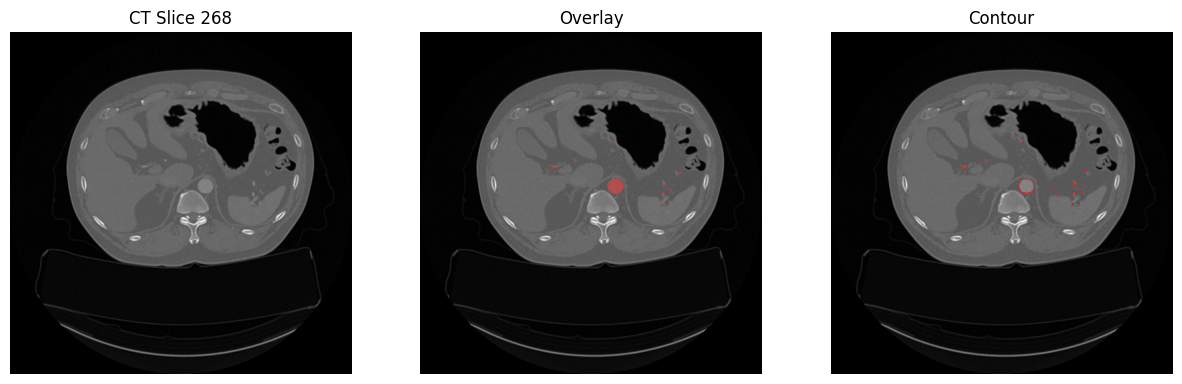

In [14]:
# CT / Mask 읽은 객체
# ct_nifti = sitk.ReadImage(...)
# mask = sitk.ReadImage(...)

# 중간 slice 보기
mid = ct_nifti.GetSize()[2] // 2

show_overlay(ct_nifti, mask, mid)

Slice: 50


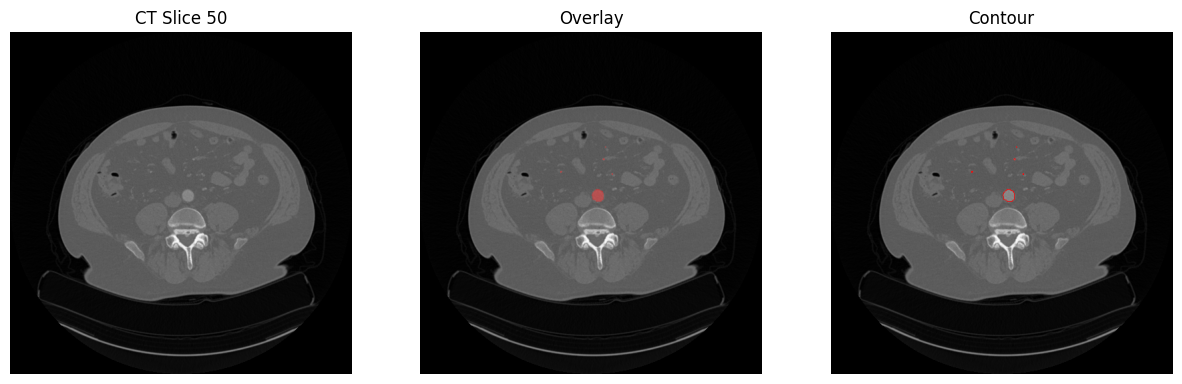

Slice: 100


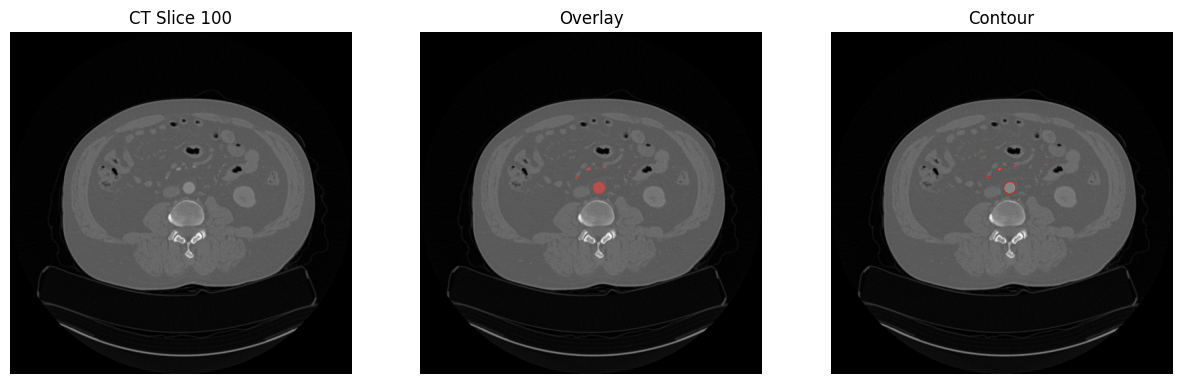

Slice: 150


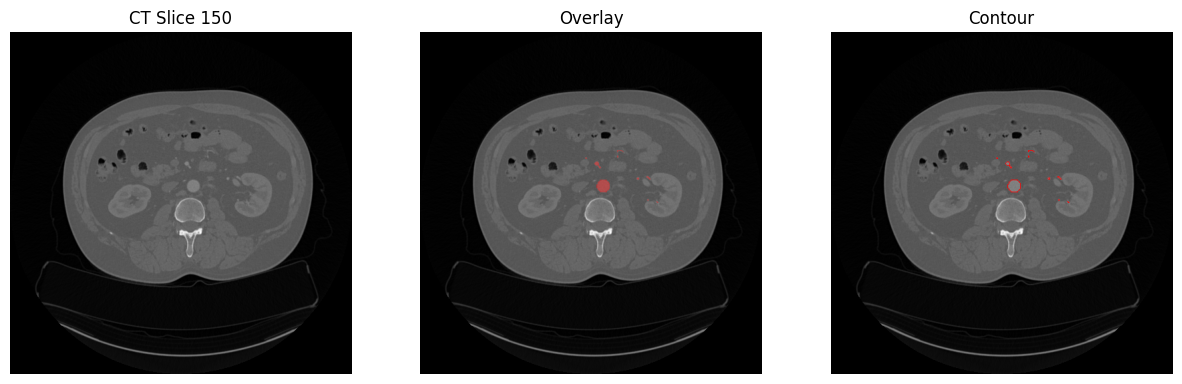

Slice: 200


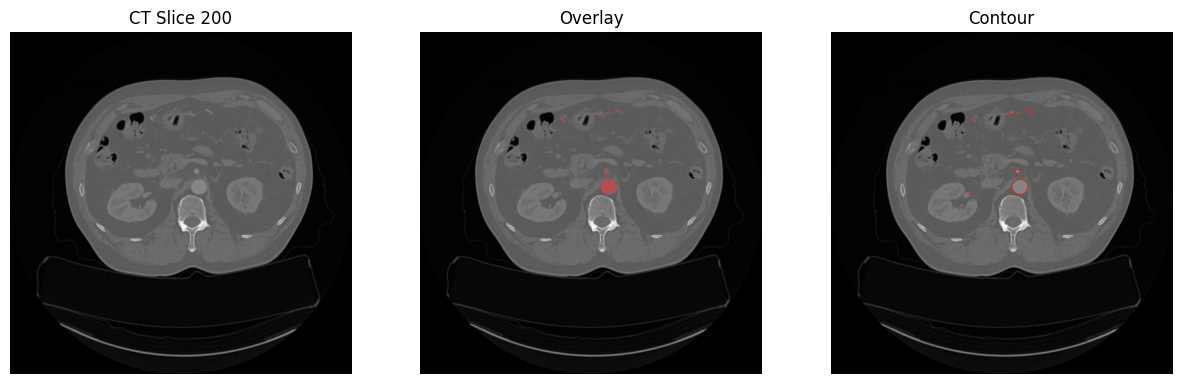

Slice: 250


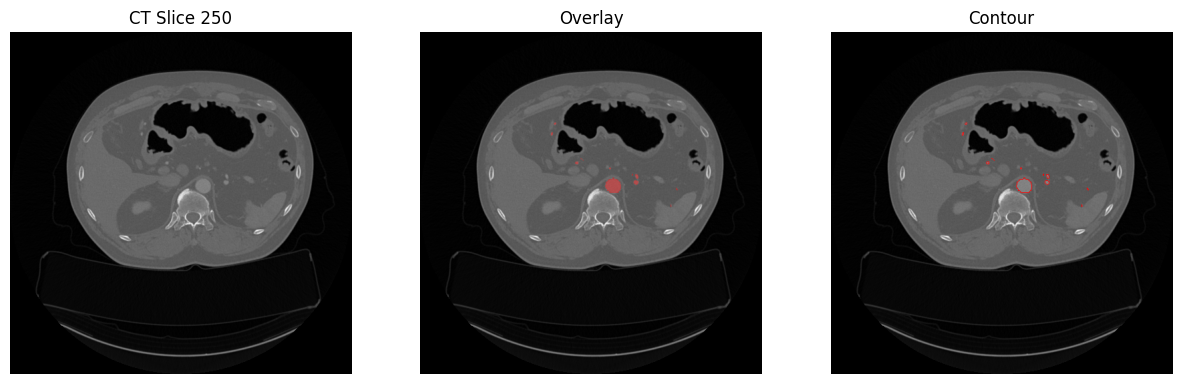

In [15]:
for z in range(50, 300, 50):
    print("Slice:", z)
    show_overlay(ct_nifti, mask, z)

### 데이터 전체 자동 변환 (CT > nifi)

In [20]:
from pathlib import Path
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

ROOT_DIR = Path("/Users/srpark/Downloads/01011")
PATIENT_ID = "01011ug_500"

# DICOM 폴더 (환자마다 동일 구조로 가정)
dcm_dir = ROOT_DIR / PATIENT_ID / "02_viewCT" / "1" / "AP"

# 기존 Whole artery mask
whole_mask_path = ROOT_DIR / PATIENT_ID / "04_MANUAL_MASK" / "1" / "AP" / "Whole_artery.nii.gz"

print("DICOM:", dcm_dir)
print("Whole mask:", whole_mask_path)

DICOM: /Users/srpark/Downloads/01011/01011ug_500/02_viewCT/1/AP
Whole mask: /Users/srpark/Downloads/01011/01011ug_500/04_MANUAL_MASK/1/AP/Whole_artery.nii.gz


In [21]:
# 반드시 네가 가져온 Hutom_DicomLoader 클래스가 이미 notebook에 로드되어 있어야 함

dcm_loader = Hutom_DicomLoader(data_dir=str(dcm_dir))
_ = dcm_loader.to_rsa()   # RAS 정렬
dcm_loader.sanity_check()

# 저장 폴더
save_dir = ROOT_DIR / "nifti_out"
save_dir.mkdir(exist_ok=True)

# Hutom 방식으로 저장
ct_nifti_path = save_dir / f"{PATIENT_ID}.nii.gz"
dcm_loader.save_nii(str(save_dir), PATIENT_ID)

print("CT NIfTI saved at:", ct_nifti_path)

----------------------------------------------------------------------------------------------------
PatientID: 01011ug_500
Direction: (np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(1.0))
PatientPosition: FFS
OriginalAffine: [[   0.9765625     0.            0.         -249.5117    ]
 [   0.            0.9765625     0.         -469.5117    ]
 [   0.            0.            0.79850746 -101.        ]
 [   0.            0.            0.            1.        ]]
PixelSpacing: [0.9765625, 0.9765625]
Image shape (536, 512, 512)
Axcode: RAS
SliceThickness: 0.7985074626865671
RASAffine: [[   0.9765625     0.            0.         -249.5117    ]
 [   0.            0.9765625     0.         -469.5117    ]
 [   0.            0.            0.79850746 -101.        ]
 [   0.            0.            0.            1.        ]]
-----------------------------------------------------------------------------

In [22]:
mask_img = sitk.ReadImage(str(whole_mask_path))
mask_arr = sitk.GetArrayFromImage(mask_img).astype(np.uint8)
print("Whole mask shape:", mask_arr.shape)

Whole mask shape: (536, 512, 512)


In [23]:
ct_img = sitk.ReadImage(str(ct_nifti_path))
ct_arr = sitk.GetArrayFromImage(ct_img).astype(np.float32)

print("CT shape:", ct_arr.shape)

CT shape: (536, 512, 512)


Slice: 218


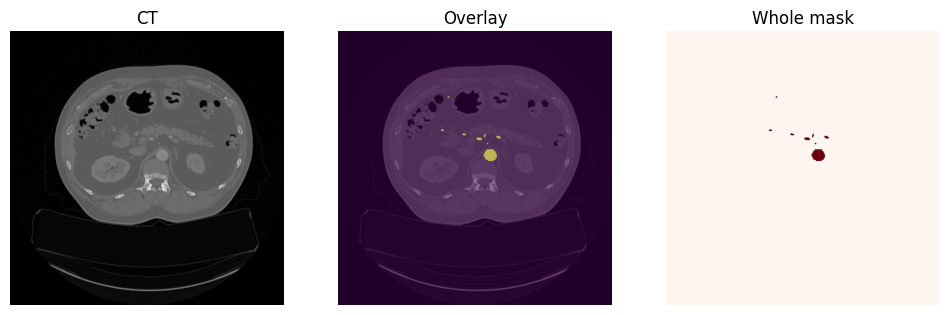

In [24]:
# label 존재하는 slice 찾기
z_has_label = mask_arr.max(axis=(1,2)) > 0
label_slices = np.where(z_has_label)[0]

z = int(label_slices[len(label_slices)//2])
print("Slice:", z)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(ct_arr[z], cmap="gray")
plt.title("CT")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(ct_arr[z], cmap="gray")
plt.imshow(mask_arr[z], alpha=0.5)
plt.title("Overlay")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(mask_arr[z], cmap="Reds")
plt.title("Whole mask")
plt.axis("off")

plt.show()

#### 01011

In [25]:
from pathlib import Path
import glob, shutil
import SimpleITK as sitk
import numpy as np

# 0. 기본 경로 설정
ROOT_DIR = Path("/Users/srpark/Downloads/01011")
RL_ROOT  = ROOT_DIR / "RL_prepared"
RL_ROOT.mkdir(exist_ok=True)

# 1. 케이스 리스트: 01011ug_* 폴더들
case_list = sorted(glob.glob(str(ROOT_DIR / "01011ug_*")))
print("Found cases:", len(case_list))
print("Sample cases:", case_list[:5])

def process_one_case(case_path: str):
    case_path = Path(case_path)
    case_id   = case_path.name
    print(f"\n=== Processing {case_id} ===")

    # (1) DICOM / Mask 경로
    dcm_dir   = case_path / "02_viewCT" / "1" / "AP"
    mask_dir  = case_path / "04_MANUAL_MASK" / "1" / "AP"
    whole_path = mask_dir / "Whole_artery.nii.gz"

    if not dcm_dir.is_dir():
        print("  ⚠️ DICOM 폴더 없음:", dcm_dir)
        return
    if not whole_path.is_file():
        print("  ⚠️ Whole_artery.nii.gz 없음:", whole_path)
        return

    # (2) 출력 폴더
    out_dir = RL_ROOT / case_id
    out_dir.mkdir(exist_ok=True)

    # ---------- 2-1. Hutom_DicomLoader로 CT NIfTI 만들기 ----------
    print("  → Hutom_DicomLoader로 CT 읽는 중...")
    dcm_loader = Hutom_DicomLoader(data_dir=str(dcm_dir))
    if dcm_loader.data is None:
        print("  ⚠️ DICOM 로딩 실패, 스킵")
        return

    dcm_loader.to_rsa()         # RAS 정렬 (내부에서 self.data 업데이트)
    dcm_loader.sanity_check()   # 한번 정보 출력해서 확인

    # ct.nii.gz 로 저장 (idname을 'ct'로 주면 파일명이 ct.nii.gz 됨)
    dcm_loader.save_nii(str(out_dir), idname="ct")
    ct_out_path = out_dir / "ct.nii.gz"
    print("  ✓ CT NIfTI 저장:", ct_out_path)

    # ---------- 2-2. Whole_artery 마스크 복사 ----------
    mask_out_path = out_dir / "whole_artery.nii.gz"
    shutil.copy2(str(whole_path), str(mask_out_path))
    print("  ✓ Whole_artery 복사:", mask_out_path)

    # ---------- 2-3. CT vs mask shape 대략 체크 ----------
    ct_img    = sitk.ReadImage(str(ct_out_path))
    mask_img  = sitk.ReadImage(str(mask_out_path))
    ct_arr    = sitk.GetArrayFromImage(ct_img)
    mask_arr  = sitk.GetArrayFromImage(mask_img)

    print("  CT shape   :", ct_arr.shape)
    print("  Mask shape :", mask_arr.shape)
    if ct_arr.shape != mask_arr.shape:
        print("  ⚠️ CT와 mask shape 다름 → 나중에 개별 확인 필요")
    else:
        print("  ✓ CT와 mask shape 일치")

    print(f"=== {case_id} 완료 ===")

# 2. 일단 1~2 케이스만 테스트
for case in case_list[:2]:
    process_one_case(case)

Found cases: 29
Sample cases: ['/Users/srpark/Downloads/01011/01011ug_500', '/Users/srpark/Downloads/01011/01011ug_501', '/Users/srpark/Downloads/01011/01011ug_502', '/Users/srpark/Downloads/01011/01011ug_503', '/Users/srpark/Downloads/01011/01011ug_504']

=== Processing 01011ug_500 ===
  → Hutom_DicomLoader로 CT 읽는 중...
----------------------------------------------------------------------------------------------------
PatientID: 01011ug_500
Direction: (np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(1.0))
PatientPosition: FFS
OriginalAffine: [[   0.9765625     0.            0.         -249.5117    ]
 [   0.            0.9765625     0.         -469.5117    ]
 [   0.            0.            0.79850746 -101.        ]
 [   0.            0.            0.            1.        ]]
PixelSpacing: [0.9765625, 0.9765625]
Image shape (536, 512, 512)
Axcode: RAS
SliceThickness: 0.7985074626865671
RAS

In [26]:
# 3. 전체 케이스에 대해 일괄 변환
for case in case_list:
    process_one_case(case)


=== Processing 01011ug_500 ===
  → Hutom_DicomLoader로 CT 읽는 중...
----------------------------------------------------------------------------------------------------
PatientID: 01011ug_500
Direction: (np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(1.0))
PatientPosition: FFS
OriginalAffine: [[   0.9765625     0.            0.         -249.5117    ]
 [   0.            0.9765625     0.         -469.5117    ]
 [   0.            0.            0.79850746 -101.        ]
 [   0.            0.            0.            1.        ]]
PixelSpacing: [0.9765625, 0.9765625]
Image shape (536, 512, 512)
Axcode: RAS
SliceThickness: 0.7985074626865671
RASAffine: [[   0.9765625     0.            0.         -249.5117    ]
 [   0.            0.9765625     0.         -469.5117    ]
 [   0.            0.            0.79850746 -101.        ]
 [   0.            0.            0.            1.        ]]
-----------

#### 01010

In [27]:

# 0. 기본 경로 설정
ROOT_DIR = Path("/Users/srpark/Downloads/01010")
RL_ROOT  = ROOT_DIR / "RL_prepared"
RL_ROOT.mkdir(exist_ok=True)

# 1. 케이스 리스트: 01010ug_* 폴더들
case_list = sorted(glob.glob(str(ROOT_DIR / "01010ug_*")))
print("Found cases:", len(case_list))
print("Sample cases:", case_list[:5])


# 3. 전체 케이스에 대해 일괄 변환
for case in case_list:
    process_one_case(case)

Found cases: 27
Sample cases: ['/Users/srpark/Downloads/01010/01010ug_1', '/Users/srpark/Downloads/01010/01010ug_10', '/Users/srpark/Downloads/01010/01010ug_11', '/Users/srpark/Downloads/01010/01010ug_133', '/Users/srpark/Downloads/01010/01010ug_134']

=== Processing 01010ug_1 ===
  → Hutom_DicomLoader로 CT 읽는 중...
----------------------------------------------------------------------------------------------------
PatientID: 01010ug_1
Direction: (np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(1.0))
PatientPosition: FFS
OriginalAffine: [[ 7.81250000e-01  0.00000000e+00  0.00000000e+00 -1.85609400e+02]
 [ 0.00000000e+00  7.81250000e-01  0.00000000e+00 -4.52609400e+02]
 [ 0.00000000e+00  0.00000000e+00  7.97507788e-01  1.26660000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
PixelSpacing: [0.78125, 0.78125]
Image shape (321, 512, 512)
Axcode: RAS
SliceThickness: 0.

#### 01015

In [28]:
# 0. 기본 경로 설정
ROOT_DIR = Path("/Users/srpark/Downloads/01015")
RL_ROOT  = ROOT_DIR / "RL_prepared"
RL_ROOT.mkdir(exist_ok=True)

# 1. 케이스 리스트: 01015ug_* 폴더들
case_list = sorted(glob.glob(str(ROOT_DIR / "01015ug_*")))
print("Found cases:", len(case_list))
print("Sample cases:", case_list[:5])

# 3. 전체 케이스에 대해 일괄 변환
for case in case_list:
    process_one_case(case)

Found cases: 20
Sample cases: ['/Users/srpark/Downloads/01015/01015ug_100', '/Users/srpark/Downloads/01015/01015ug_70', '/Users/srpark/Downloads/01015/01015ug_71', '/Users/srpark/Downloads/01015/01015ug_72', '/Users/srpark/Downloads/01015/01015ug_73']

=== Processing 01015ug_100 ===
  → Hutom_DicomLoader로 CT 읽는 중...
----------------------------------------------------------------------------------------------------
PatientID: 01015ug_100
Direction: (np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(1.0))
PatientPosition: FFS
OriginalAffine: [[   0.73828125    0.            0.         -180.6309    ]
 [   0.            0.73828125    0.         -436.1309    ]
 [   0.            0.            0.99586777  456.8       ]
 [   0.            0.            0.            1.        ]]
PixelSpacing: [0.73828125, 0.73828125]
Image shape (242, 512, 512)
Axcode: RAS
SliceThickness: 0.9958677685950411
RASAf

#### 01018

In [29]:
# 0. 기본 경로 설정
ROOT_DIR = Path("/Users/srpark/Downloads/01018")
RL_ROOT  = ROOT_DIR / "RL_prepared"
RL_ROOT.mkdir(exist_ok=True)

# 1. 케이스 리스트: 01018ug_* 폴더들
case_list = sorted(glob.glob(str(ROOT_DIR / "01018ug_*")))
print("Found cases:", len(case_list))
print("Sample cases:", case_list[:5])

# 3. 전체 케이스에 대해 일괄 변환
for case in case_list:
    process_one_case(case)

Found cases: 27
Sample cases: ['/Users/srpark/Downloads/01018/01018ug_105', '/Users/srpark/Downloads/01018/01018ug_70', '/Users/srpark/Downloads/01018/01018ug_71', '/Users/srpark/Downloads/01018/01018ug_72', '/Users/srpark/Downloads/01018/01018ug_73']

=== Processing 01018ug_105 ===
  → Hutom_DicomLoader로 CT 읽는 중...
----------------------------------------------------------------------------------------------------
PatientID: 01018ug_105
Direction: (np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(1.0))
PatientPosition: FFS
OriginalAffine: [[   0.81640625    0.            0.         -204.5918    ]
 [   0.            0.81640625    0.         -445.5918    ]
 [   0.            0.            0.99655172 -137.4       ]
 [   0.            0.            0.            1.        ]]
PixelSpacing: [0.81640625, 0.81640625]
Image shape (290, 512, 512)
Axcode: RAS
SliceThickness: 0.996551724137931
RASAff

### 오류 데이터 QC

CT: /Users/srpark/Downloads/01018/RL_prepared/01018ug_74/ct.nii.gz
Mask: /Users/srpark/Downloads/01018/RL_prepared/01018ug_74/whole_artery.nii.gz
CT shape   : (287, 512, 512)
Mask shape : (286, 512, 512)
Slice: 0


/var/folders/78/kff0l0ts7cnc7n54tdllr0qc0000gn/T/ipykernel_3135/3795201849.py:51: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/78/kff0l0ts7cnc7n54tdllr0qc0000gn/T/ipykernel_3135/3795201849.py:51: UserWarning: Glyph 53685 (\N{HANGUL SYLLABLE TONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/78/kff0l0ts7cnc7n54tdllr0qc0000gn/T/ipykernel_3135/3795201849.py:51: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/78/kff0l0ts7cnc7n54tdllr0qc0000gn/T/ipykernel_3135/3795201849.py:51: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/78/kff0l0ts7cnc7n54tdllr0qc0000gn/T/ipykernel_3135/3795201849.py:51: UserWarning: Glyph 47564 (\N{HANGUL SYLLABLE MAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


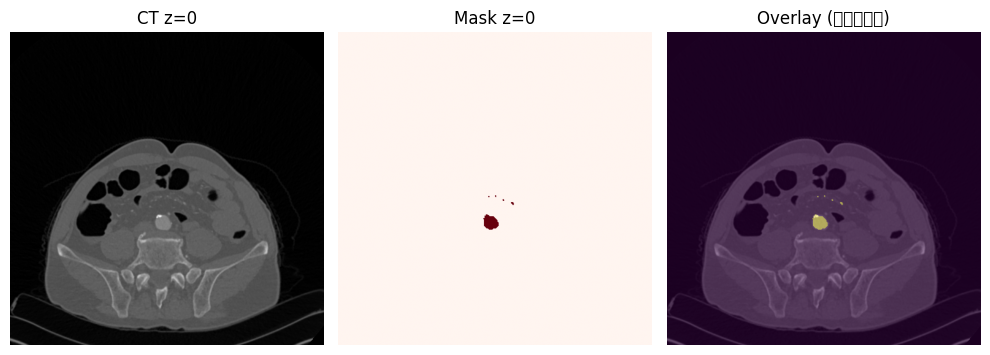

Slice: 57


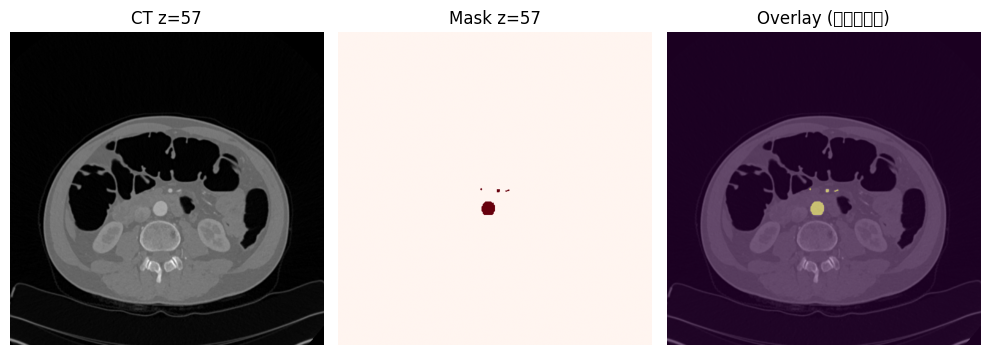

Slice: 114


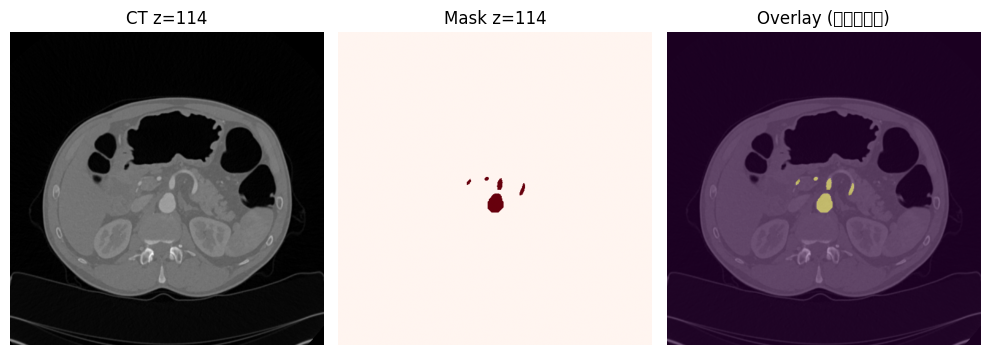

Slice: 171


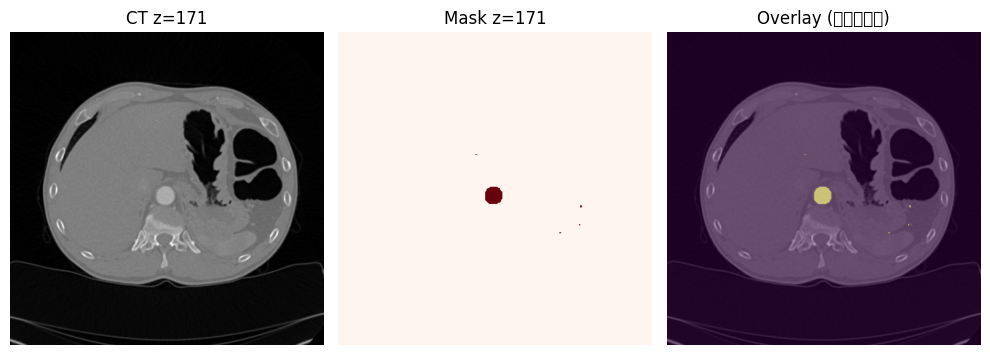

Slice: 228


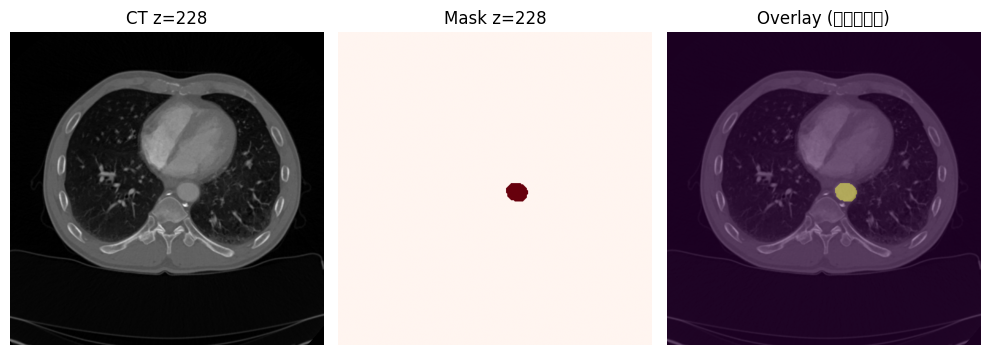

Slice: 285


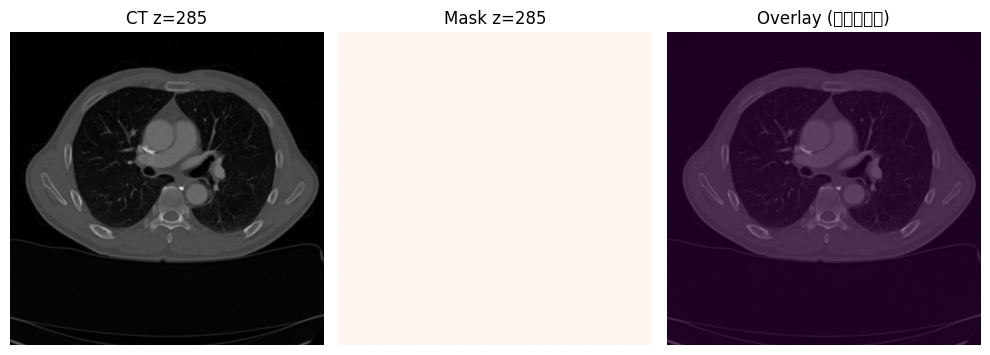

In [ ]:
# 01010ug_10, 01018ug_74 두 케이스는 CT와 mask shape가 다름 - 제외

from pathlib import Path
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

ROOT_DIR = Path("/Users/srpark/Downloads/01018")
RL_ROOT  = ROOT_DIR / "RL_prepared"

CASE_ID = "01018ug_74"   # 여기만 바꿔가면서 확인하면 됨

ct_path   = RL_ROOT / CASE_ID / "ct.nii.gz"
mask_path = RL_ROOT / CASE_ID / "whole_artery.nii.gz"

print("CT:", ct_path)
print("Mask:", mask_path)

ct_img   = sitk.ReadImage(str(ct_path))
mask_img = sitk.ReadImage(str(mask_path))

ct_arr   = sitk.GetArrayFromImage(ct_img).astype(np.float32)  # (z,y,x)
mask_arr = sitk.GetArrayFromImage(mask_img).astype(np.uint8)

print("CT shape   :", ct_arr.shape)
print("Mask shape :", mask_arr.shape)

# z 인덱스 범위 맞춰서 몇 개만 보기
max_z = min(ct_arr.shape[0], mask_arr.shape[0])

for z in range(0, max_z, max_z // 5 or 1):
    print("Slice:", z)
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(ct_arr[z], cmap="gray")
    plt.title(f"CT z={z}")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask_arr[z], cmap="Reds")
    plt.title(f"Mask z={z}")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(ct_arr[z], cmap="gray")
    plt.imshow(mask_arr[z], alpha=0.4)
    plt.title("Overlay (공통부분만)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

### 전체 데이터 확인 - png 저장

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from skimage.exposure import rescale_intensity
from skimage.segmentation import find_boundaries
from skimage.util import img_as_float
from pathlib import Path
import nibabel as nib
import os

# ------------------------------------------------------
# 1. CT + Mask 오버레이 함수
# ------------------------------------------------------
def visualize_mask_overlay_skimage(
    image,
    mask,
    alpha=0.35,
    overlay_color=(1.0, 0.85, 0.0),   # 노란색 overlay
    contour_color=(1, 0, 0),          # 빨간색 테두리
):
    """
    단일 슬라이스에 대해:
    - CT (image)
    - mask overlay (overlay_color)
    - mask boundary (contour_color)
    를 3패널로 그려주는 함수
    """
    # CT를 [0,1]로 정규화
    image = rescale_intensity(image, in_range='image', out_range=(0, 1))
    image = img_as_float(image)

    # grayscale → RGB
    if image.ndim == 2:
        image = color.gray2rgb(image)

    # ---- overlay (노란색) ----
    colored_mask = np.zeros_like(image)
    colored_mask[mask > 0] = overlay_color
    overlay = image * (1 - alpha) + colored_mask * alpha

    # ---- boundary (빨간색) ----
    boundaries = find_boundaries(mask, mode='inner')
    contour_img = overlay.copy()
    contour_img[boundaries] = contour_color

    # ---- 그림 그리기 ----
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(image, cmap="gray")
    axs[0].set_title("CT")
    axs[0].axis("off")

    axs[1].imshow(overlay)
    axs[1].set_title("Overlay (Yellow)")
    axs[1].axis("off")

    axs[2].imshow(contour_img)
    axs[2].set_title("Overlay + Red Boundary")
    axs[2].axis("off")

    plt.tight_layout()
    return overlay, fig


# ------------------------------------------------------
# 2. 한 케이스에 대해 PNG 한 장 저장
# ------------------------------------------------------
def save_overlay_for_case(case_dir: Path, out_dir: Path):
    """
    case_dir: RL_prepared/01010ug_1 같은 폴더
    out_dir : PNG 저장할 상위 폴더
    """

    # --- CT NIfTI 찾기 (mask 이름이 들어가지 않은 *.nii.gz) ---
    ct_candidates = [
        f for f in case_dir.glob("*.nii.gz")
        if not any(k in f.name.lower() for k in ["whole", "main", "extra", "artery", "mask"])
    ]

    if len(ct_candidates) == 0:
        print(f"[SKIP] CT NIfTI not found in {case_dir}")
        return
    if len(ct_candidates) > 1:
        print(f"[WARN] Multiple CT candidates in {case_dir}, using: {ct_candidates[0].name}")
    ct_path = ct_candidates[0]

    # --- mask NIfTI 찾기 (whole & artery 들어있는 파일 우선) ---
    mask_candidates = [f for f in case_dir.glob("*.nii.gz") if "whole" in f.name.lower() and "artery" in f.name.lower()]
    if not mask_candidates:
        # fallback: 아무 artery/mask라도
        mask_candidates = [f for f in case_dir.glob("*.nii.gz") if "artery" in f.name.lower() or "mask" in f.name.lower()]
    if not mask_candidates:
        print(f"[SKIP] Mask NIfTI not found in {case_dir}")
        return
    if len(mask_candidates) > 1:
        print(f"[WARN] Multiple mask candidates in {case_dir}, using: {mask_candidates[0].name}")
    mask_path = mask_candidates[0]

    # --- 로드 ---
    ct_vol   = nib.load(str(ct_path)).get_fdata()
    mask_vol = nib.load(str(mask_path)).get_fdata()

    if ct_vol.shape != mask_vol.shape:
        print(f"[WARN] Shape mismatch in {case_dir.name}: CT {ct_vol.shape}, mask {mask_vol.shape}")
        # 그래도 강행하려면 여기서 리턴 대신 pass 가능
        return

    # --- 슬라이스 선택: 마스크가 가장 많이 있는 z 슬라이스 ---
    mask_per_slice = mask_vol.sum(axis=(0, 1))
    slice_idx = int(mask_per_slice.argmax())

    ct_slice   = ct_vol[:, :, slice_idx]
    mask_slice = mask_vol[:, :, slice_idx]

    # --- 오버레이 그림 만들기 ---
    _, fig = visualize_mask_overlay_skimage(ct_slice, mask_slice)

    # --- 저장 ---
    os.makedirs(out_dir, exist_ok=True)
    save_path = out_dir / f"{case_dir.name}_slice_{slice_idx}.png"
    fig.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close(fig)

    print(f"✓ Saved: {save_path}")


# ------------------------------------------------------
# 3. RL_prepared 전체 케이스에 대해 반복 실행
# ------------------------------------------------------

# 이 노트북이 RL_PROJECT/notebooks 에 있다고 가정하면:
ROOT_DIR = Path("..") / "data" / "RL_prepared"

# PNG는 RL_prepared 옆에 overlay_png 라는 폴더에 저장
OUT_DIR = ROOT_DIR / "overlay_png"
OUT_DIR.mkdir(exist_ok=True)

case_dirs = sorted([d for d in ROOT_DIR.iterdir() if d.is_dir()])

print(f"총 케이스 수: {len(case_dirs)}")
for case_dir in case_dirs:
    save_overlay_for_case(case_dir, OUT_DIR)

총 케이스 수: 103
✓ Saved: ../data/RL_prepared/overlay_png/01010ug_1_slice_163.png
✓ Saved: ../data/RL_prepared/overlay_png/01010ug_11_slice_119.png
✓ Saved: ../data/RL_prepared/overlay_png/01010ug_133_slice_182.png
✓ Saved: ../data/RL_prepared/overlay_png/01010ug_134_slice_184.png
✓ Saved: ../data/RL_prepared/overlay_png/01010ug_135_slice_168.png
✓ Saved: ../data/RL_prepared/overlay_png/01010ug_136_slice_173.png
✓ Saved: ../data/RL_prepared/overlay_png/01010ug_164_slice_292.png
✓ Saved: ../data/RL_prepared/overlay_png/01010ug_165_slice_211.png
✓ Saved: ../data/RL_prepared/overlay_png/01010ug_166_slice_159.png
✓ Saved: ../data/RL_prepared/overlay_png/01010ug_167_slice_131.png
✓ Saved: ../data/RL_prepared/overlay_png/01010ug_168_slice_42.png
✓ Saved: ../data/RL_prepared/overlay_png/01010ug_169_slice_137.png
✓ Saved: ../data/RL_prepared/overlay_png/01010ug_170_slice_167.png
✓ Saved: ../data/RL_prepared/overlay_png/01010ug_171_slice_160.png
✓ Saved: ../data/RL_prepared/overlay_png/01010ug_172_

In [39]:
## 전체 데이터 셋의 shape 검사 코드

from pathlib import Path
import nibabel as nib


data_root = Path("/Users/srpark/Projects/RL_project/data/RL_prepared")

bad_cases = []
good_cases = []

for case_dir in sorted(data_root.iterdir()):
    if not case_dir.is_dir():
        continue
    if case_dir.name.startswith("overlay"):
        continue

    ct_path   = case_dir / "ct.nii.gz"
    mask_path = case_dir / "Whole_artery.nii.gz"

    if not ct_path.exists() or not mask_path.exists():
        print(f"[SKIP] {case_dir.name} → 파일 없음")
        continue

    try:
        ct   = nib.load(str(ct_path)).get_fdata()
        mask = nib.load(str(mask_path)).get_fdata()

        if ct.shape != mask.shape:
            print(f"❌ Shape mismatch: {case_dir.name}")
            print(f"   CT   : {ct.shape}")
            print(f"   MASK : {mask.shape}\n")
            bad_cases.append((case_dir.name, ct.shape, mask.shape))
        else:
            good_cases.append(case_dir.name)

    except Exception as e:
        print(f"⚠ 오류 발생: {case_dir.name}", e)

print("\n===============================")
print("검사 완료!")
print(f"정상 케이스 수: {len(good_cases)}")
print(f"Shape mismatch 케이스 수: {len(bad_cases)}")
print("===============================")

if len(bad_cases) > 0:
    print("\n❌ Shape mismatch 케이스 목록:")
    for name, ct_s, m_s in bad_cases:
        print(f" - {name}: CT {ct_s} / MASK {m_s}")
else:
    print("\n모든 케이스의 shape이 정상입니다!")


검사 완료!
정상 케이스 수: 99
Shape mismatch 케이스 수: 0

모든 케이스의 shape이 정상입니다!


## Mask data 전처리

In [40]:
#### 한 마스크 내에서 연결 성분 분석 (connected component analysis) - 예제 코드

from pathlib import Path
import numpy as np
import nibabel as nib
from scipy.ndimage import label  # 없으면: pip install scipy

# 1) 케이스 폴더 / 마스크 경로 설정
CASE_DIR = Path("/Users/srpark/Projects/RL_project/data/RL_prepared/01018ug_81")
MASK_NAME = "Whole_artery.nii.gz"

mask_nii = nib.load(str(CASE_DIR / MASK_NAME))
mask = mask_nii.get_fdata()

# 2) 이진화 (0/1)
mask_bin = (mask > 0.5).astype(np.uint8)

print("mask shape:", mask_bin.shape)
print("총 vessel voxel 수:", int(mask_bin.sum()))

# 3) 3D 연결 성분 라벨링
#    구조(structure)를 어떻게 쓰느냐에 따라:
#    - 6-connectivity (직교 이웃만 연결)
#    - 18, 26-connectivity (대각선 포함)
#    보통 26-connectivity 많이 씀
structure = np.ones((3, 3, 3), dtype=int)  # 26-connectivity
labels, num_comp = label(mask_bin, structure=structure)

print("연결 성분(component) 개수:", num_comp)

# 4) 각 컴포넌트 별 voxel 개수 출력
voxel_counts = np.bincount(labels.ravel().astype(np.int64))  # label = 0 은 background
for idx, cnt in enumerate(voxel_counts[1:], start=1):
    print(f"  - component {idx:3d}: {cnt:6d} voxels")

# 5) 가장 큰 덩어리 비율 확인 (noise 섬이 많은지 체크)
if num_comp > 0:
    largest_label = voxel_counts[1:].argmax() + 1
    largest_count = voxel_counts[largest_label]
    total_vessel = mask_bin.sum()
    print(f"\n가장 큰 component label: {largest_label}")
    print(f"가장 큰 component voxel 수: {largest_count}")
    print(f"전체 vessel voxel 중 비율: {largest_count/total_vessel:.3f}")

mask shape: (512, 512, 281)
총 vessel voxel 수: 227730
연결 성분(component) 개수: 3
  - component   1: 227016 voxels
  - component   2:    200 voxels
  - component   3:    514 voxels

가장 큰 component label: 1
가장 큰 component voxel 수: 227016
전체 vessel voxel 중 비율: 0.997


In [ ]:
# 전체 데이터셋에 대해 연결 성분 분석 후 가장 큰 덩어리만 남기는 정제 코드

import os
from pathlib import Path
import numpy as np
import nibabel as nib
from scipy.ndimage import label

DATA_ROOT = Path("/Users/srpark/Projects/RL_project/data/RL_prepared")
SAVE_ROOT = Path("/Users/srpark/Projects/RL_project/data/processed/RL_cleaned")
SAVE_ROOT.mkdir(parents=True, exist_ok=True)

MASK_NAME = "Whole_artery.nii.gz"
CT_NAME   = "ct.nii.gz"

def keep_largest_component(mask):
    """가장 큰 connected-component만 남기기"""
    mask_bin = (mask > 0.5).astype(np.uint8)

    structure = np.ones((3,3,3), dtype=np.uint8)
    labels, num = label(mask_bin, structure=structure)

    if num <= 1:
        return mask_bin  # 이미 하나면 그대로 반환

    voxel_counts = np.bincount(labels.flatten())
    largest_label = np.argmax(voxel_counts[1:]) + 1

    cleaned = (labels == largest_label).astype(np.uint8)
    return cleaned

def clean_dataset():
    case_dirs = sorted([d for d in DATA_ROOT.iterdir() if d.is_dir()])

    print(f"총 {len(case_dirs)} 케이스 정제 시작...")

    for case in case_dirs:
        ct_path = case / CT_NAME
        mask_path = case / MASK_NAME

        if not ct_path.exists() or not mask_path.exists():
            print(f"❌ Missing files in {case.name}")
            continue

        ct = nib.load(str(ct_path)).get_fdata()
        mask = nib.load(str(mask_path)).get_fdata()

        cleaned = keep_largest_component(mask)

        # 저장 위치 준비
        out_dir = SAVE_ROOT / case.name
        out_dir.mkdir(exist_ok=True)

        # CT 저장
        nib.save(nib.Nifti1Image(ct, np.eye(4)), out_dir / CT_NAME)

        # Cleaned Mask 저장
        nib.save(nib.Nifti1Image(cleaned.astype(np.uint8), np.eye(4)),
                 out_dir / "whole_artery_cleaned.nii.gz")

        print(f"✔ {case.name}: saved cleaned mask")

    print("\n🎉 모든 케이스 정제 완료!")

clean_dataset()

In [45]:
# 전체 데이터셋에 대해 연결 성분 분석 수행 코드

import os
from pathlib import Path
import numpy as np
import nibabel as nib
from scipy.ndimage import label  # pip install scipy

DATA_ROOT = Path("/Users/srpark/Projects/RL_project/data/processed/RL_cleaned")
MASK_NAME = "whole_artery_cleaned.nii.gz"   # ← RL_cleaned 안에 실제 파일명으로 수정

def analyze_connected_components(mask_path: Path):
    """하나의 NIfTI 마스크 파일에서 연결성분 분석"""
    try:
        mask_nii = nib.load(str(mask_path))
    except:
        print(f"❌ Cannot load: {mask_path}")
        return None
    
    mask = mask_nii.get_fdata()
    mask_bin = (mask > 0.5).astype(np.uint8)

    if mask_bin.sum() == 0:
        return {
            "valid": False,
            "reason": "empty_mask"
        }

    # 3D 26-connected labeling
    structure = np.ones((3,3,3), dtype=np.int32)
    labels, num_comp = label(mask_bin, structure=structure)

    voxel_counts = np.bincount(labels.ravel().astype(np.int64))

    # component 0은 background라 제외
    comp_counts = voxel_counts[1:]

    if len(comp_counts) == 0:
        return {
            "valid": False,
            "reason": "no_component"
        }

    total_voxels = comp_counts.sum()
    largest = comp_counts.max()
    ratio = largest / total_voxels

    return {
        "valid": True,
        "num_comp": int(num_comp),
        "comp_counts": comp_counts.tolist(),
        "largest_ratio": float(ratio),
        "total_voxels": int(total_voxels)
    }


def scan_all_cases(data_root: Path):
    print("=== Connected Component Dataset Analysis ===\n")

    results = []

    case_dirs = sorted([d for d in data_root.iterdir() if d.is_dir()])

    for case_dir in case_dirs:
        mask_path = case_dir / MASK_NAME
        if not mask_path.exists():
            print(f"⚠️ Mask missing: {case_dir.name}")
            continue

        info = analyze_connected_components(mask_path)

        if info is None or not info["valid"]:
            print(f"[{case_dir.name}] ❌ Mask invalid ({info})")
            continue

        num_comp = info["num_comp"]
        ratio = info["largest_ratio"]

        results.append((case_dir.name, num_comp, ratio, info))

        # 관심 있는 케이스만 출력: component > 1
        if num_comp > 1:
            print(f"🔍 [{case_dir.name}] Components = {num_comp}, Largest ratio = {ratio:.3f}")
            print(f"   component sizes = {info['comp_counts']}")
    
    print("\n=== Summary ===")
    total_cases = len(results)
    multi_comp_cases = [r for r in results if r[1] > 1]

    print(f"총 케이스 수: {total_cases}")
    print(f"여러 개 component 가진 케이스 수: {len(multi_comp_cases)}")
    print(f"비율: {len(multi_comp_cases)/total_cases:.3f}")

    print("\n🔥 여러 Component 사례 (요약):")
    for case_name, num_comp, ratio, _ in multi_comp_cases:
        print(f" - {case_name}: comp={num_comp}, largest={ratio:.3f}")

    return results


# 실행
results = scan_all_cases(DATA_ROOT)

=== Connected Component Dataset Analysis ===


=== Summary ===
총 케이스 수: 99
여러 개 component 가진 케이스 수: 0
비율: 0.000

🔥 여러 Component 사례 (요약):


In [49]:
# CT 전체 대비 마스크 볼륨 비율 계산 코드

import os
from pathlib import Path
import numpy as np
import nibabel as nib

# 경로 / 파일명 설정
DATA_ROOT = Path("/Users/srpark/Projects/RL_project/data/processed/RL_cleaned")
CT_NAME   = "ct.nii.gz"
MASK_NAME = "whole_artery_cleaned.nii.gz"   # 실제 파일명에 맞게!

def analyze_volume_fraction(data_root: Path):
    results = []  # (case_name, frac, mask_voxels, total_voxels)

    case_dirs = sorted([d for d in data_root.iterdir() if d.is_dir()])

    print(f"총 {len(case_dirs)} 케이스에서 volume fraction 계산 시작...\n")

    for case_dir in case_dirs:
        ct_path   = case_dir / CT_NAME
        mask_path = case_dir / MASK_NAME

        if not ct_path.exists() or not mask_path.exists():
            print(f"⚠️ Missing file in {case_dir.name} (ct or mask)")
            continue

        try:
            ct_nii   = nib.load(str(ct_path))
            mask_nii = nib.load(str(mask_path))
        except Exception as e:
            print(f"❌ Load error in {case_dir.name}: {e}")
            continue

        ct   = ct_nii.get_fdata()
        mask = mask_nii.get_fdata()

        if ct.shape != mask.shape:
            print(f"⚠️ Shape mismatch in {case_dir.name}: ct{ct.shape}, mask{mask.shape}")
            continue

        total_voxels = np.prod(ct.shape)
        mask_voxels  = int((mask > 0.5).sum())

        if total_voxels == 0:
            print(f"⚠️ Zero-size volume in {case_dir.name}")
            continue

        frac = mask_voxels / total_voxels  # CT 전체 voxel 중 vessel 비율

        results.append((case_dir.name, frac, mask_voxels, int(total_voxels)))

    # 결과 없으면 종료
    if not results:
        print("❗ 유효한 케이스가 없습니다.")
        return []

    # frac 기준으로 정렬
    results_sorted = sorted(results, key=lambda x: x[1])

    print("\n=== 케이스별 vessel volume fraction (mask / CT 전체) ===")
    for name, frac, mv, tv in results_sorted:
        print(f"{name}: frac={frac:.6f}  (mask={mv}, total={tv})")

    # 통계 요약
    fracs = np.array([r[1] for r in results_sorted])
    mean  = fracs.mean()
    std   = fracs.std()
    q25, q50, q75 = np.percentile(fracs, [25, 50, 75])

    print("\n=== Summary Statistics ===")
    print(f"케이스 수: {len(results_sorted)}")
    print(f"평균:     {mean:.6f}")
    print(f"표준편차: {std:.6f}")
    print(f"25/50/75 percentile: {q25:.6f}, {q50:.6f}, {q75:.6f}")
    print(f"최소:     {fracs.min():.6f}")
    print(f"최대:     {fracs.max():.6f}")

    # outlier 후보: 가장 작은 5개 / 가장 큰 5개
    k = min(5, len(results_sorted))

    print("\n🔎 Vessel 비율이 가장 작은 케이스 (bottom)")
    for name, frac, mv, tv in results_sorted[:k]:
        print(f"  - {name}: frac={frac:.6f} (mask={mv}, total={tv})")

    print("\n🔎 Vessel 비율이 가장 큰 케이스 (top)")
    for name, frac, mv, tv in results_sorted[-k:]:
        print(f"  - {name}: frac={frac:.6f} (mask={mv}, total={tv})")

    return results_sorted

# 실행
volume_fractions = analyze_volume_fraction(DATA_ROOT)

총 99 케이스에서 volume fraction 계산 시작...


=== 케이스별 vessel volume fraction (mask / CT 전체) ===
01010ug_177: frac=0.001083  (mask=93950, total=86769664)
01010ug_171: frac=0.001331  (mask=90356, total=67895296)
01015ug_91: frac=0.001426  (mask=109166, total=76546048)
01011ug_500: frac=0.001451  (mask=203910, total=140509184)
01010ug_4: frac=0.001457  (mask=122566, total=84148224)
01010ug_136: frac=0.001534  (mask=106592, total=69468160)
01011ug_504: frac=0.001566  (mask=174868, total=111673344)
01010ug_169: frac=0.001567  (mask=111703, total=71303168)
01010ug_6: frac=0.001574  (mask=132410, total=84148224)
01015ug_92: frac=0.001574  (mask=111028, total=70516736)
01011ug_522: frac=0.001581  (mask=163663, total=103546880)
01010ug_7: frac=0.001607  (mask=155007, total=96468992)
01015ug_70: frac=0.001675  (mask=147571, total=88080384)
01011ug_519: frac=0.001715  (mask=160952, total=93847552)
01010ug_8: frac=0.001728  (mask=133669, total=77332480)
01015ug_93: frac=0.001745  (mask=124415, total=7130

## Centerline 생성_skeletonize 3D

In [ ]:
import numpy as np
import nibabel as nib
from pathlib import Path

# 🔁 skeletonize_3d 또는 skeletonize 자동 fallback
try:
    from skimage.morphology import skeletonize_3d as skeletonize_centerline
except ImportError:
    from skimage.morphology import skeletonize as skeletonize_centerline


# 🔁 새로운 데이터 경로 (largest component만 남긴 cleaned 버전)
DATA_ROOT = Path("/Users/srpark/Projects/RL_project/data/processed/RL_cleaned")

MASK_NAME = "whole_artery_cleaned.nii.gz"   # 마스크 파일 이름
SAVE_NAME = "centerline.nii.gz"     # 저장할 centerline 파일 이름


def generate_centerline(mask_volume: np.ndarray):
    """
    mask_volume: binary vessel mask (0/1)
    return: 3D skeleton (centerline) 0/1
    """
    mask_bin = (mask_volume > 0.5).astype(np.uint8)

    # skeletonize_centerline 은 skeletonize_3d 또는 fallback skeletonize
    centerline = skeletonize_centerline(mask_bin)

    return centerline.astype(np.uint8)


def process_all_cases(data_root: Path):
    case_dirs = sorted([p for p in data_root.iterdir() if p.is_dir()])

    print(f"=== Generating Centerlines for {len(case_dirs)} cases ===")

    for case in case_dirs:
        mask_path = case / MASK_NAME
        save_path = case / SAVE_NAME

        if not mask_path.exists():
            print(f"⚠️ No mask found in {case.name}, skipped.")
            continue

        # 이미 centerline이 있으면 건너뛰기
        if save_path.exists():
            print(f"✔ Already exists: {case.name}")
            continue

        try:
            mask_nii = nib.load(str(mask_path))
            mask = mask_nii.get_fdata()
        except Exception as e:
            print(f"❌ Load failed on {case.name}: {e}")
            continue

        # centerline 생성
        centerline = generate_centerline(mask)

        # 저장
        out_img = nib.Nifti1Image(centerline, affine=mask_nii.affine)
        nib.save(out_img, save_path)

        print(f"✔ Centerline saved for case: {case.name}")

    print("\n🎉 All centerlines generated!")


# 실행
process_all_cases(DATA_ROOT)

## Centerline_nii 데이터 QC

In [13]:
import numpy as np
import nibabel as nib
from pathlib import Path

import matplotlib
matplotlib.use("Agg")   # 화면 안 띄우고 파일만 저장할 때 (서버/VSCode용)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (3D projection 등록용)


def plot_vessel_and_centerline_points(
    vessel_nii_path: Path,
    centerline_nii_path: Path,
    out_png_path: Path,
    max_vessel_points: int = 60000,
):
    """
    vessel_nii_path   : whole_artery_cleaned.nii.gz 같은 혈관 mask
    centerline_nii_path : centerline.nii.gz
    out_png_path      : 저장할 PNG 경로
    max_vessel_points : 혈관 voxel 중 랜덤 샘플 개수 (속도/가독성용)
    """

    # --- NIfTI 로드 & 이진화 ---
    vessel_nii = nib.load(str(vessel_nii_path))
    vessel = vessel_nii.get_fdata()
    vessel_bin = vessel > 0.5

    center_nii = nib.load(str(centerline_nii_path))
    center = center_nii.get_fdata()
    center_bin = center > 0.5

    # --- 좌표 뽑기: (z,y,x) -> (x,y,z) 순서로 변환해서 plotting ---
    vz, vy, vx = np.nonzero(vessel_bin)
    vessel_coords = np.stack([vx, vy, vz], axis=1)   # (N,3)

    cz, cy, cx = np.nonzero(center_bin)
    center_coords = np.stack([cx, cy, cz], axis=1)   # (M,3)

    # 혈관 voxel이 너무 많으면 랜덤 샘플링 (속도/시인성 확보)
    if len(vessel_coords) > max_vessel_points:
        idx = np.random.choice(len(vessel_coords), max_vessel_points, replace=False)
        vessel_coords = vessel_coords[idx]

    # --- 3D scatter plot ---
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")

    # 혈관: 옅은 파란 점
    ax.scatter(
        vessel_coords[:, 0],
        vessel_coords[:, 1],
        vessel_coords[:, 2],
        s=0.5,
        alpha=0.1,
        color="tab:blue",
        label="vessel"
    )

    # 센터라인: 진한 빨간 점 (조금 크게)
    if len(center_coords) > 0:
        ax.scatter(
            center_coords[:, 0],
            center_coords[:, 1],
            center_coords[:, 2],
            s=0.1,
            alpha=1.0,
            color="red",
            label="centerline"
        )

    # 축/타이틀 정리
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    case_name = vessel_nii_path.parent.name
    ax.set_title(f"{case_name}  |  vessel voxels vs centerline")

    # 박스 비율 맞추기 (비뚤어지지 않게)
    all_pts = np.vstack([vessel_coords, center_coords]) if len(center_coords) > 0 else vessel_coords
    xmin, ymin, zmin = all_pts.min(axis=0)
    xmax, ymax, zmax = all_pts.max(axis=0)
    ax.set_box_aspect([xmax - xmin + 1, ymax - ymin + 1, zmax - zmin + 1])

    # 위/옆에서 보기 좋은 각도 대충 고정
    ax.view_init(elev=120, azim=-90)

    ax.legend(loc="upper right")
    plt.tight_layout()

    out_png_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(str(out_png_path), dpi=200)
    plt.close(fig)
    
# ===== 여기부터 실제 경로 적용 =====
ROOT = Path("/Users/srpark/Projects/RL_project/data/processed/RL_cleaned")
case_dir = ROOT / "01018ug_98"

vessel_path = case_dir / "whole_artery_cleaned.nii.gz"
center_path = case_dir / "centerline.nii.gz"

out_png = ROOT / "RL_qc_plots" / f"{case_dir.name}_vessel_centerline.png"

plot_vessel_and_centerline_points(
    vessel_nii_path=vessel_path,
    centerline_nii_path=center_path,
    out_png_path=out_png,
    max_vessel_points=60000,  # 느리면 30000 정도로 줄여도 됨
)

print("PNG saved to:", out_png)

PNG saved to: /Users/srpark/Projects/RL_project/data/processed/RL_cleaned/RL_qc_plots/01018ug_98_vessel_centerline.png


In [14]:
from pathlib import Path

ROOT = Path("/Users/srpark/Projects/RL_project/data/processed/RL_cleaned")
OUT_ROOT = ROOT / "RL_qc_plots"

for case_dir in sorted(ROOT.iterdir()):
    if not case_dir.is_dir():
        continue

    vessel_path = case_dir / "whole_artery_cleaned.nii.gz"
    center_path = case_dir / "centerline.nii.gz"

    if not vessel_path.exists() or not center_path.exists():
        print(f"[SKIP] {case_dir.name}: missing vessel/centerline")
        continue

    out_png = OUT_ROOT / f"{case_dir.name}_vessel_centerline.png"
    print(f"[{case_dir.name}] -> {out_png.name}")

    plot_vessel_and_centerline_points(
        vessel_nii_path=vessel_path,
        centerline_nii_path=center_path,
        out_png_path=out_png,
        max_vessel_points=60000,  # 필요하면 조절
    )

print("\n✅ All done. PNGs saved in:", OUT_ROOT)

[01010ug_1] -> 01010ug_1_vessel_centerline.png
[01010ug_11] -> 01010ug_11_vessel_centerline.png
[01010ug_133] -> 01010ug_133_vessel_centerline.png
[01010ug_134] -> 01010ug_134_vessel_centerline.png
[01010ug_135] -> 01010ug_135_vessel_centerline.png
[01010ug_136] -> 01010ug_136_vessel_centerline.png
[01010ug_164] -> 01010ug_164_vessel_centerline.png
[01010ug_165] -> 01010ug_165_vessel_centerline.png
[01010ug_166] -> 01010ug_166_vessel_centerline.png
[01010ug_167] -> 01010ug_167_vessel_centerline.png
[01010ug_168] -> 01010ug_168_vessel_centerline.png
[01010ug_169] -> 01010ug_169_vessel_centerline.png
[01010ug_170] -> 01010ug_170_vessel_centerline.png
[01010ug_171] -> 01010ug_171_vessel_centerline.png
[01010ug_172] -> 01010ug_172_vessel_centerline.png
[01010ug_174] -> 01010ug_174_vessel_centerline.png
[01010ug_176] -> 01010ug_176_vessel_centerline.png
[01010ug_177] -> 01010ug_177_vessel_centerline.png
[01010ug_2] -> 01010ug_2_vessel_centerline.png
[01010ug_3] -> 01010ug_3_vessel_centerlin

## Mask data 전처리 _ v2

In [35]:
########### 전체 데이터셋에 대해 연결 성분 분석 후 요약 CSV 저장 코드

import nibabel as nib
import numpy as np
from scipy.ndimage import label
from pathlib import Path
import csv

BASE_DIR = Path("/Users/srpark/Projects/RL_project/data/processed/RL_cleaned")
OUTPUT_CSV = "vessel_component_summary_with_ratio.csv"

def analyze_components(mask):
    labeled, n_comp = label(mask)

    # component sizes: bincount index = component label
    sizes = np.bincount(labeled.ravel())
    sizes[0] = 0  # background는 제외

    total_voxels = sizes.sum()

    if n_comp > 0:
        largest_size = sizes.max()
        largest_ratio = largest_size / total_voxels * 100
        small_components = (sizes < 100) & (sizes > 0)
        n_small = small_components.sum()
    else:
        largest_size = 0
        largest_ratio = 0
        n_small = 0

    return n_comp, largest_size, n_small, total_voxels, largest_ratio


def run_analysis():
    results = []

    for case_dir in BASE_DIR.iterdir():
        if not case_dir.is_dir():
            continue

        case_id = case_dir.name
        vessel_path = case_dir / "whole_artery_cleaned.nii.gz"

        if not vessel_path.exists():
            print(f"❌ {case_id}: whole_artery_cleaned.nii.gz 없음")
            continue

        print(f"\n🔍 Processing {case_id}...")

        nii = nib.load(str(vessel_path))
        mask = nii.get_fdata() > 0

        # Analyze
        n_comp, largest, n_small, total_vox, ratio = analyze_components(mask)

        print(f"   → 총 component 개수: {n_comp}")
        print(f"   → largest component voxel 수: {largest:,}")
        print(f"   → 전체 voxel 수: {total_vox:,}")
        print(f"   → largest 비율: {ratio:.2f}%")
        print(f"   → 작은 component(<100 voxel) 개수: {n_small}")

        results.append([case_id, n_comp, largest, total_vox, ratio, n_small])

    # save CSV
    with open(OUTPUT_CSV, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            "case_id",
            "total_components",
            "largest_component_voxels",
            "total_voxels",
            "largest_ratio_percent",
            "small_components(<100)"
        ])
        writer.writerows(results)

    print(f"\n📁 결과 저장됨: {OUTPUT_CSV}")


if __name__ == "__main__":
    run_analysis()


🔍 Processing 01015ug_74...
   → 총 component 개수: 22
   → largest component voxel 수: 187,116
   → 전체 voxel 수: 187,367
   → largest 비율: 99.87%
   → 작은 component(<100 voxel) 개수: 21

🔍 Processing 01015ug_89...
   → 총 component 개수: 44
   → largest component voxel 수: 182,245
   → 전체 voxel 수: 183,133
   → largest 비율: 99.52%
   → 작은 component(<100 voxel) 개수: 42

🔍 Processing 01010ug_174...
   → 총 component 개수: 115
   → largest component voxel 수: 190,007
   → 전체 voxel 수: 192,564
   → largest 비율: 98.67%
   → 작은 component(<100 voxel) 개수: 111

🔍 Processing 01015ug_72...
   → 총 component 개수: 27
   → largest component voxel 수: 125,722
   → 전체 voxel 수: 126,006
   → largest 비율: 99.77%
   → 작은 component(<100 voxel) 개수: 26

🔍 Processing 01015ug_75...
   → 총 component 개수: 49
   → largest component voxel 수: 159,357
   → 전체 voxel 수: 159,606
   → largest 비율: 99.84%
   → 작은 component(<100 voxel) 개수: 48

🔍 Processing 01010ug_172...
   → 총 component 개수: 160
   → largest component voxel 수: 258,185
   → 전체 voxel

In [36]:
def keep_largest_component_only(mask_data, connectivity='26'):
    """
    가장 큰 connected component만 남기기
    
    Args:
        mask_data: 3D numpy array
        connectivity: '6' or '26' (연결성 기준)
    
    Returns:
        cleaned mask with only largest component
    """
    # Binary로 변환 (0/255 케이스도 처리)
    mask_bin = (mask_data > 0).astype(np.uint8)
    
    # 연결성 구조 정의
    if connectivity == '26':
        structure = np.ones((3,3,3), dtype=np.uint8)
    else:  # 6-connectivity
        structure = None
    
    # Connected components
    labels, num_components = label(mask_bin, structure=structure)
    
    print(f"  Found {num_components} component(s)")
    
    if num_components <= 1:
        return mask_bin
    
    # 각 component 크기 계산
    component_sizes = np.bincount(labels.flatten())
    
    # 0은 배경이므로 제외하고 가장 큰 component 찾기
    largest_label = np.argmax(component_sizes[1:]) + 1
    largest_size = component_sizes[largest_label]
    
    print(f"  Largest component: {largest_size:,} voxels")
    print(f"  Removing: {mask_bin.sum() - largest_size:,} voxels")
    
    # Largest component만 남기기
    cleaned = (labels == largest_label).astype(np.uint8)
    
    return cleaned

In [41]:
import os
from pathlib import Path
import numpy as np
import nibabel as nib
from scipy.ndimage import label
from tqdm import tqdm

def process_single_case(case_name, input_base, output_base):
    """
    단일 케이스 처리
    """
    # 경로 설정
    input_dir = Path(input_base) / case_name
    output_dir = Path(output_base) / case_name
    
    # 입력 파일
    mask_path = input_dir / "whole_artery.nii.gz"
    ct_path = input_dir / "ct.nii.gz"
    
    if not mask_path.exists():
        print(f"❌ Mask not found: {mask_path}")
        return False
    
    print(f"\n📂 Processing: {case_name}")
    
    # 출력 디렉토리 생성
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Mask 처리
    mask_nii = nib.load(mask_path)
    mask_data = mask_nii.get_fdata()
    
    # Largest component만 남기기
    cleaned = keep_largest_component_only(mask_data, connectivity='26')
    
    # 원본 affine과 header 유지!
    cleaned_nii = nib.Nifti1Image(
        cleaned.astype(np.uint8),
        mask_nii.affine,  # 원본 affine 유지
        mask_nii.header   # 원본 header 유지
    )
    
    # 저장
    output_mask = output_dir / "whole_artery_cleaned.nii.gz"
    nib.save(cleaned_nii, output_mask)
    print(f"  ✅ Saved mask: {output_mask.name}")
    
    # CT 복사 (있으면)
    if ct_path.exists():
        ct_nii = nib.load(ct_path)
        output_ct = output_dir / "ct.nii.gz"
        nib.save(ct_nii, output_ct)
        print(f"  ✅ Copied CT: {output_ct.name}")
    
    # 최종 검증
    _, final_components = label(cleaned, structure=np.ones((3,3,3)))
    if final_components != 1:
        print(f"  ⚠️ Warning: Still has {final_components} components!")
        return False
    
    return True


def process_all_cases():
    """
    모든 케이스 처리
    """
    # 경로 설정 (수정 필요!)
    INPUT_BASE = "/Users/srpark/Projects/RL_project/data/processed/RL_prepared"
    OUTPUT_BASE = "/Users/srpark/Projects/RL_project/data/processed/RL_cleaned_v2"
    
    input_path = Path(INPUT_BASE)
    output_path = Path(OUTPUT_BASE)
    
    # 출력 폴더 생성
    output_path.mkdir(parents=True, exist_ok=True)
    
    # 모든 케이스 찾기
    case_dirs = sorted([d for d in input_path.iterdir() if d.is_dir()])
    
    print(f"="*60)
    print(f"🚀 Largest Component 전처리 시작")
    print(f"  입력: {INPUT_BASE}")
    print(f"  출력: {OUTPUT_BASE}")
    print(f"  총 케이스: {len(case_dirs)}개")
    print(f"="*60)
    
    # 처리 결과 기록
    results = {
        'success': [],
        'warning': [],
        'failed': []
    }
    
    # 모든 케이스 처리
    for case_dir in tqdm(case_dirs, desc="Processing"):
        case_name = case_dir.name
        
        try:
            success = process_single_case(case_name, INPUT_BASE, OUTPUT_BASE)
            
            if success:
                results['success'].append(case_name)
            else:
                results['warning'].append(case_name)
                
        except Exception as e:
            print(f"❌ Error in {case_name}: {e}")
            results['failed'].append(case_name)
    
    # 최종 보고
    print(f"\n{'='*60}")
    print(f"📊 처리 완료!")
    print(f"  ✅ 성공: {len(results['success'])}개")
    print(f"  ⚠️ 경고: {len(results['warning'])}개")
    print(f"  ❌ 실패: {len(results['failed'])}개")
    
    if results['warning']:
        print(f"\n경고 케이스:")
        for case in results['warning'][:10]:
            print(f"  - {case}")
    
    if results['failed']:
        print(f"\n실패 케이스:")
        for case in results['failed']:
            print(f"  - {case}")
    
    # 결과 저장
    import json
    result_file = output_path / "processing_results.json"
    with open(result_file, 'w') as f:
        json.dump(results, f, indent=2)
    print(f"\n💾 결과 저장: {result_file}")
    
    return results

results = process_all_cases()

🚀 Largest Component 전처리 시작
  입력: /Users/srpark/Projects/RL_project/data/processed/RL_prepared
  출력: /Users/srpark/Projects/RL_project/data/processed/RL_cleaned_v2
  총 케이스: 99개


Processing:   0%|          | 0/99 [00:00<?, ?it/s]


📂 Processing: 01010ug_1
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:   1%|          | 1/99 [00:09<15:24,  9.43s/it]


📂 Processing: 01010ug_11
  Found 2 component(s)
  Largest component: 181,910 voxels
  Removing: 34.0 voxels
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:   2%|▏         | 2/99 [00:17<13:38,  8.44s/it]


📂 Processing: 01010ug_133
  Found 2 component(s)
  Largest component: 148,707 voxels
  Removing: 4.0 voxels
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:   3%|▎         | 3/99 [00:26<14:00,  8.76s/it]


📂 Processing: 01010ug_134
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:   4%|▍         | 4/99 [00:34<13:39,  8.63s/it]


📂 Processing: 01010ug_135
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:   5%|▌         | 5/99 [00:41<12:29,  7.97s/it]


📂 Processing: 01010ug_136
  Found 3 component(s)
  Largest component: 106,592 voxels
  Removing: 191.0 voxels
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:   6%|▌         | 6/99 [00:49<12:09,  7.84s/it]


📂 Processing: 01010ug_164
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:   7%|▋         | 7/99 [00:57<12:17,  8.01s/it]


📂 Processing: 01010ug_165
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:   8%|▊         | 8/99 [01:04<11:31,  7.60s/it]


📂 Processing: 01010ug_166
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:   9%|▉         | 9/99 [01:11<11:08,  7.42s/it]


📂 Processing: 01010ug_167
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  10%|█         | 10/99 [01:18<10:51,  7.32s/it]


📂 Processing: 01010ug_168
  Found 2 component(s)
  Largest component: 188,382 voxels
  Removing: 683.0 voxels
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  11%|█         | 11/99 [01:25<10:52,  7.41s/it]


📂 Processing: 01010ug_169
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  12%|█▏        | 12/99 [01:33<10:37,  7.33s/it]


📂 Processing: 01010ug_170
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  13%|█▎        | 13/99 [01:40<10:36,  7.40s/it]


📂 Processing: 01010ug_171
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  14%|█▍        | 14/99 [01:47<10:21,  7.31s/it]


📂 Processing: 01010ug_172
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  15%|█▌        | 15/99 [01:57<11:03,  7.90s/it]


📂 Processing: 01010ug_174
  Found 2 component(s)
  Largest component: 192,564 voxels
  Removing: 90.0 voxels
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  16%|█▌        | 16/99 [02:05<11:10,  8.08s/it]


📂 Processing: 01010ug_176
  Found 2 component(s)
  Largest component: 146,292 voxels
  Removing: 41.0 voxels
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  17%|█▋        | 17/99 [02:14<11:14,  8.23s/it]


📂 Processing: 01010ug_177
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  18%|█▊        | 18/99 [02:23<11:28,  8.50s/it]


📂 Processing: 01010ug_2
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  19%|█▉        | 19/99 [02:31<11:12,  8.40s/it]


📂 Processing: 01010ug_3
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  20%|██        | 20/99 [02:42<12:00,  9.12s/it]


📂 Processing: 01010ug_4
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  21%|██        | 21/99 [02:51<11:57,  9.19s/it]


📂 Processing: 01010ug_5
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  22%|██▏       | 22/99 [03:01<12:01,  9.37s/it]


📂 Processing: 01010ug_6
  Found 8 component(s)
  Largest component: 132,410 voxels
  Removing: 652.0 voxels
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  23%|██▎       | 23/99 [03:11<12:02,  9.51s/it]


📂 Processing: 01010ug_7
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  24%|██▍       | 24/99 [03:21<12:17,  9.83s/it]


📂 Processing: 01010ug_8
  Found 2 component(s)
  Largest component: 133,669 voxels
  Removing: 1.0 voxels
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  25%|██▌       | 25/99 [03:30<11:43,  9.51s/it]


📂 Processing: 01011ug_500
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  26%|██▋       | 26/99 [03:45<13:24, 11.02s/it]


📂 Processing: 01011ug_501
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  27%|██▋       | 27/99 [03:54<12:40, 10.56s/it]


📂 Processing: 01011ug_502
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  28%|██▊       | 28/99 [04:06<13:02, 11.03s/it]


📂 Processing: 01011ug_503
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  29%|██▉       | 29/99 [04:17<12:40, 10.87s/it]


📂 Processing: 01011ug_504
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  30%|███       | 30/99 [04:28<12:32, 10.90s/it]


📂 Processing: 01011ug_505
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  31%|███▏      | 31/99 [04:39<12:34, 11.09s/it]


📂 Processing: 01011ug_506
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  32%|███▏      | 32/99 [04:51<12:35, 11.28s/it]


📂 Processing: 01011ug_507
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  33%|███▎      | 33/99 [05:03<12:32, 11.40s/it]


📂 Processing: 01011ug_508
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  34%|███▍      | 34/99 [05:14<12:18, 11.36s/it]


📂 Processing: 01011ug_509
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  35%|███▌      | 35/99 [05:26<12:18, 11.54s/it]


📂 Processing: 01011ug_510
  Found 2 component(s)
  Largest component: 249,925 voxels
  Removing: 406.0 voxels
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  36%|███▋      | 36/99 [05:40<13:02, 12.42s/it]


📂 Processing: 01011ug_511
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  37%|███▋      | 37/99 [05:52<12:28, 12.07s/it]


📂 Processing: 01011ug_512
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  38%|███▊      | 38/99 [06:03<12:02, 11.84s/it]


📂 Processing: 01011ug_513
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  39%|███▉      | 39/99 [06:15<12:00, 12.00s/it]


📂 Processing: 01011ug_514
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  40%|████      | 40/99 [06:27<11:40, 11.87s/it]


📂 Processing: 01011ug_515
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  41%|████▏     | 41/99 [06:35<10:31, 10.90s/it]


📂 Processing: 01011ug_516
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  42%|████▏     | 42/99 [06:46<10:20, 10.88s/it]


📂 Processing: 01011ug_517
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  43%|████▎     | 43/99 [06:56<09:47, 10.48s/it]


📂 Processing: 01011ug_519
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  44%|████▍     | 44/99 [07:05<09:17, 10.13s/it]


📂 Processing: 01011ug_520
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  45%|████▌     | 45/99 [07:15<09:06, 10.13s/it]


📂 Processing: 01011ug_521
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  46%|████▋     | 46/99 [07:26<09:03, 10.26s/it]


📂 Processing: 01011ug_522
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  47%|████▋     | 47/99 [07:36<08:56, 10.32s/it]


📂 Processing: 01011ug_523
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  48%|████▊     | 48/99 [07:48<09:01, 10.62s/it]


📂 Processing: 01011ug_525
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  49%|████▉     | 49/99 [07:57<08:29, 10.19s/it]


📂 Processing: 01011ug_526
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  51%|█████     | 50/99 [08:06<08:04,  9.88s/it]


📂 Processing: 01011ug_527
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  52%|█████▏    | 51/99 [08:15<07:40,  9.59s/it]


📂 Processing: 01011ug_528
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  53%|█████▎    | 52/99 [08:23<07:07,  9.09s/it]


📂 Processing: 01011ug_529
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  54%|█████▎    | 53/99 [08:33<07:14,  9.45s/it]


📂 Processing: 01011ug_530
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  55%|█████▍    | 54/99 [08:42<06:56,  9.26s/it]


📂 Processing: 01015ug_100
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  56%|█████▌    | 55/99 [08:48<06:09,  8.40s/it]


📂 Processing: 01015ug_70
  Found 2 component(s)
  Largest component: 147,571 voxels
  Removing: 28.0 voxels
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  57%|█████▋    | 56/99 [08:58<06:22,  8.89s/it]


📂 Processing: 01015ug_71
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  58%|█████▊    | 57/99 [09:08<06:19,  9.03s/it]


📂 Processing: 01015ug_72
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  59%|█████▊    | 58/99 [09:14<05:39,  8.28s/it]


📂 Processing: 01015ug_74
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  60%|█████▉    | 59/99 [09:22<05:26,  8.17s/it]


📂 Processing: 01015ug_75
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  61%|██████    | 60/99 [09:30<05:16,  8.13s/it]


📂 Processing: 01015ug_76
  Found 2 component(s)
  Largest component: 168,635 voxels
  Removing: 353.0 voxels
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  62%|██████▏   | 61/99 [09:38<05:10,  8.16s/it]


📂 Processing: 01015ug_79
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  63%|██████▎   | 62/99 [09:46<04:51,  7.87s/it]


📂 Processing: 01015ug_89
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  64%|██████▎   | 63/99 [09:53<04:43,  7.87s/it]


📂 Processing: 01015ug_90
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  65%|██████▍   | 64/99 [10:01<04:36,  7.90s/it]


📂 Processing: 01015ug_91
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  66%|██████▌   | 65/99 [10:09<04:29,  7.93s/it]


📂 Processing: 01015ug_92
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  67%|██████▋   | 66/99 [10:17<04:15,  7.73s/it]


📂 Processing: 01015ug_93
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  68%|██████▊   | 67/99 [10:24<04:03,  7.61s/it]


📂 Processing: 01015ug_94
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  69%|██████▊   | 68/99 [10:31<03:52,  7.50s/it]


📂 Processing: 01015ug_95
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  70%|██████▉   | 69/99 [10:38<03:42,  7.41s/it]


📂 Processing: 01015ug_96
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  71%|███████   | 70/99 [10:46<03:36,  7.48s/it]


📂 Processing: 01015ug_97
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  72%|███████▏  | 71/99 [10:53<03:26,  7.37s/it]


📂 Processing: 01015ug_98
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  73%|███████▎  | 72/99 [11:01<03:22,  7.49s/it]


📂 Processing: 01015ug_99
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  74%|███████▎  | 73/99 [11:09<03:18,  7.64s/it]


📂 Processing: 01018ug_105
  Found 2 component(s)
  Largest component: 193,651 voxels
  Removing: 443.0 voxels
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  75%|███████▍  | 74/99 [11:18<03:19,  7.97s/it]


📂 Processing: 01018ug_70
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  76%|███████▌  | 75/99 [11:25<03:09,  7.89s/it]


📂 Processing: 01018ug_71
  Found 2 component(s)
  Largest component: 173,830 voxels
  Removing: 380.0 voxels
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  77%|███████▋  | 76/99 [11:33<02:59,  7.80s/it]


📂 Processing: 01018ug_72
  Found 2 component(s)
  Largest component: 229,306 voxels
  Removing: 113.0 voxels
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  78%|███████▊  | 77/99 [11:41<02:51,  7.81s/it]


📂 Processing: 01018ug_73
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  79%|███████▉  | 78/99 [11:48<02:40,  7.64s/it]


📂 Processing: 01018ug_75
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  80%|███████▉  | 79/99 [11:55<02:30,  7.53s/it]


📂 Processing: 01018ug_76
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  81%|████████  | 80/99 [12:03<02:21,  7.47s/it]


📂 Processing: 01018ug_77
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  82%|████████▏ | 81/99 [12:10<02:13,  7.44s/it]


📂 Processing: 01018ug_78
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  83%|████████▎ | 82/99 [12:16<01:58,  6.96s/it]


📂 Processing: 01018ug_79
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  84%|████████▍ | 83/99 [12:24<01:59,  7.45s/it]


📂 Processing: 01018ug_80
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  85%|████████▍ | 84/99 [12:32<01:50,  7.36s/it]


📂 Processing: 01018ug_81
  Found 3 component(s)
  Largest component: 227,016 voxels
  Removing: 714.0 voxels
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  86%|████████▌ | 85/99 [12:40<01:47,  7.66s/it]


📂 Processing: 01018ug_82
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  87%|████████▋ | 86/99 [12:48<01:40,  7.71s/it]


📂 Processing: 01018ug_84
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  88%|████████▊ | 87/99 [12:55<01:29,  7.49s/it]


📂 Processing: 01018ug_85
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  89%|████████▉ | 88/99 [13:02<01:22,  7.54s/it]


📂 Processing: 01018ug_86
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  90%|████████▉ | 89/99 [13:09<01:12,  7.28s/it]


📂 Processing: 01018ug_87
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  91%|█████████ | 90/99 [13:17<01:06,  7.40s/it]


📂 Processing: 01018ug_88
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  92%|█████████▏| 91/99 [13:25<01:00,  7.51s/it]


📂 Processing: 01018ug_89
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  93%|█████████▎| 92/99 [13:32<00:52,  7.50s/it]


📂 Processing: 01018ug_90
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  94%|█████████▍| 93/99 [13:40<00:45,  7.53s/it]


📂 Processing: 01018ug_91
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  95%|█████████▍| 94/99 [13:47<00:36,  7.37s/it]


📂 Processing: 01018ug_94
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  96%|█████████▌| 95/99 [13:54<00:29,  7.47s/it]


📂 Processing: 01018ug_95
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  97%|█████████▋| 96/99 [14:03<00:23,  7.81s/it]


📂 Processing: 01018ug_96
  Found 2 component(s)
  Largest component: 269,239 voxels
  Removing: 72.0 voxels
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  98%|█████████▊| 97/99 [14:11<00:15,  7.82s/it]


📂 Processing: 01018ug_97
  Found 2 component(s)
  Largest component: 193,180 voxels
  Removing: 12.0 voxels
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing:  99%|█████████▉| 98/99 [14:19<00:08,  8.05s/it]


📂 Processing: 01018ug_98
  Found 1 component(s)
  ✅ Saved mask: whole_artery_cleaned.nii.gz
  ✅ Copied CT: ct.nii.gz


Processing: 100%|██████████| 99/99 [14:27<00:00,  8.77s/it]


📊 처리 완료!
  ✅ 성공: 99개
  ⚠️ 경고: 0개
  ❌ 실패: 0개

💾 결과 저장: /Users/srpark/Projects/RL_project/data/processed/RL_cleaned_v2/processing_results.json


## Centerline 전처리_V2

### centerline v1 : cleaned mask v2 + skimage_skletonize library

In [4]:
# ==== 셀 1: 기본 import + 경로 설정 ====
import numpy as np
import nibabel as nib
from pathlib import Path
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt

# 환경에 맞게 수정
DATA_ROOT = Path("/Users/srpark/Projects/RL_project/data/processed/RL_cleaned_v2")
MASK_NAME = "whole_artery_cleaned.nii.gz"   # 마스크 파일 이름

In [70]:
import os
from pathlib import Path

import nibabel as nib
import numpy as np
from skimage.morphology import skeletonize

# ==========================
# 경로 / 파일 이름 설정
# ==========================
DATA_ROOT = Path("/Users/srpark/Projects/RL_project/data/processed/RL_cleaned_v2")
MASK_NAME = "whole_artery_cleaned.nii.gz"   # 혈관 마스크 이름
CL_NAME   = "centerline_v1.nii.gz"        # 새로 만들 센터라인 파일 이름

def make_centerline_for_case(case_dir: Path):
    case_id = case_dir.name
    mask_path = case_dir / MASK_NAME

    if not mask_path.exists():
        print(f"[{case_id}] ❌ {MASK_NAME} 없음, 스킵")
        return

    # --- 마스크 로딩 ---
    nii = nib.load(str(mask_path))
    mask = nii.get_fdata() > 0   # bool

    vessel_voxels = int(mask.sum())
    if vessel_voxels == 0:
        print(f"[{case_id}] ⚠️ vessel 마스크가 비어 있음, 스킵")
        return

    print(f"\n=== {case_id} ===")
    print(f"  vessel voxels: {vessel_voxels:,}")

    # --- skeletonize (3D 지원) ---
    # skimage.morphology.skeletonize 는 다차원 입력에서 thinning 수행
    skel = skeletonize(mask)          # bool
    skel = skel.astype(np.uint8)      # 0/1 로 저장

    cl_voxels = int(skel.sum())
    print(f"  centerline voxels: {cl_voxels:,}")

    # --- NIfTI 저장 ---
    cl_nii = nib.Nifti1Image(skel, affine=nii.affine, header=nii.header)
    out_path = case_dir / CL_NAME
    nib.save(cl_nii, str(out_path))

    print(f"  ✅ saved: {out_path}")

def make_centerlines_for_all():
    case_dirs = sorted([d for d in DATA_ROOT.iterdir() if d.is_dir()])

    print(f"총 케이스 수: {len(case_dirs)}\n")

    for case_dir in case_dirs:
        make_centerline_for_case(case_dir)

if __name__ == "__main__":
    make_centerlines_for_all()

총 케이스 수: 99


=== 01010ug_1 ===
  vessel voxels: 178,992
  centerline voxels: 4,378
  ✅ saved: /Users/srpark/Projects/RL_project/data/processed/RL_cleaned_v2/01010ug_1/centerline_v1.nii.gz

=== 01010ug_11 ===
  vessel voxels: 181,910
  centerline voxels: 3,415
  ✅ saved: /Users/srpark/Projects/RL_project/data/processed/RL_cleaned_v2/01010ug_11/centerline_v1.nii.gz

=== 01010ug_133 ===
  vessel voxels: 148,707
  centerline voxels: 3,653
  ✅ saved: /Users/srpark/Projects/RL_project/data/processed/RL_cleaned_v2/01010ug_133/centerline_v1.nii.gz

=== 01010ug_134 ===
  vessel voxels: 152,327
  centerline voxels: 4,226
  ✅ saved: /Users/srpark/Projects/RL_project/data/processed/RL_cleaned_v2/01010ug_134/centerline_v1.nii.gz

=== 01010ug_135 ===
  vessel voxels: 119,869
  centerline voxels: 2,580
  ✅ saved: /Users/srpark/Projects/RL_project/data/processed/RL_cleaned_v2/01010ug_135/centerline_v1.nii.gz

=== 01010ug_136 ===
  vessel voxels: 106,592
  centerline voxels: 2,589
  ✅ saved: /Users/sr

In [56]:
## centerline 플롯 함수 + 실제 경로 적용 예제

import numpy as np
import nibabel as nib
from pathlib import Path

import matplotlib
matplotlib.use("Agg")   # 화면 안 띄우고 파일만 저장할 때 (서버/VSCode용)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (3D projection 등록용)


def plot_vessel_and_centerline_points(
    vessel_nii_path: Path,
    centerline_nii_path: Path,
    out_png_path: Path,
    max_vessel_points: int = 60000,
):
    """
    vessel_nii_path   : whole_artery_cleaned.nii.gz 같은 혈관 mask
    centerline_nii_path :   centerline_v1.nii.gz
    out_png_path      : 저장할 PNG 경로
    max_vessel_points : 혈관 voxel 중 랜덤 샘플 개수 (속도/가독성용)
    """

    # --- NIfTI 로드 & 이진화 ---
    vessel_nii = nib.load(str(vessel_nii_path))
    vessel = vessel_nii.get_fdata()
    vessel_bin = vessel > 0.5

    center_nii = nib.load(str(centerline_nii_path))
    center = center_nii.get_fdata()
    center_bin = center > 0.5

    # --- 좌표 뽑기: (z,y,x) -> (x,y,z) 순서로 변환해서 plotting ---
    vz, vy, vx = np.nonzero(vessel_bin)
    vessel_coords = np.stack([vx, vy, vz], axis=1)   # (N,3)

    cz, cy, cx = np.nonzero(center_bin)
    center_coords = np.stack([cx, cy, cz], axis=1)   # (M,3)

    # 혈관 voxel이 너무 많으면 랜덤 샘플링 (속도/시인성 확보)
    if len(vessel_coords) > max_vessel_points:
        idx = np.random.choice(len(vessel_coords), max_vessel_points, replace=False)
        vessel_coords = vessel_coords[idx]

    # --- 3D scatter plot ---
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")

    # 혈관: 옅은 파란 점
    ax.scatter(
        vessel_coords[:, 0],
        vessel_coords[:, 1],
        vessel_coords[:, 2],
        s=0.5,
        alpha=0.1,
        color="tab:blue",
        label="vessel"
    )

    # 센터라인: 진한 빨간 점 (조금 크게)
    if len(center_coords) > 0:
        ax.scatter(
            center_coords[:, 0],
            center_coords[:, 1],
            center_coords[:, 2],
            s=0.1,
            alpha=1.0,
            color="red",
            label="centerline"
        )

    # 축/타이틀 정리
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    case_name = vessel_nii_path.parent.name
    ax.set_title(f"{case_name}  |  vessel voxels vs centerline")

    # 박스 비율 맞추기 (비뚤어지지 않게)
    all_pts = np.vstack([vessel_coords, center_coords]) if len(center_coords) > 0 else vessel_coords
    xmin, ymin, zmin = all_pts.min(axis=0)
    xmax, ymax, zmax = all_pts.max(axis=0)
    ax.set_box_aspect([xmax - xmin + 1, ymax - ymin + 1, zmax - zmin + 1])

    # 위/옆에서 보기 좋은 각도 대충 고정
    ax.view_init(elev=120, azim=-90)

    ax.legend(loc="upper right")
    plt.tight_layout()

    out_png_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(str(out_png_path), dpi=200)
    plt.close(fig)
    
# ===== 여기부터 실제 경로 적용 =====
ROOT = Path("/Users/srpark/Projects/RL_project/data/processed/RL_cleaned_V2")
case_dir = ROOT / "01018ug_98"

vessel_path = case_dir / "whole_artery_cleaned.nii.gz"
center_path = case_dir / "centerline_v1.nii.gz"

out_png = ROOT / "centerline_v1_qc_plots" / f"{case_dir.name}_vessel_centerline.png"

plot_vessel_and_centerline_points(
    vessel_nii_path=vessel_path,
    centerline_nii_path=center_path,
    out_png_path=out_png,
    max_vessel_points=60000,  # 느리면 30000 정도로 줄여도 됨
)

print("PNG saved to:", out_png)

PNG saved to: /Users/srpark/Projects/RL_project/data/processed/RL_cleaned_V2/centerline_v1_qc_plots/01018ug_98_vessel_centerline.png


In [57]:
# 전체 데이터셋에 대해 플롯 생성 코드

from pathlib import Path

ROOT = Path("/Users/srpark/Projects/RL_project/data/processed/RL_cleaned_v2")
OUT_ROOT = ROOT / "centerline_v1_qc_plots"

for case_dir in sorted(ROOT.iterdir()):
    if not case_dir.is_dir():
        continue

    vessel_path = case_dir / "whole_artery_cleaned.nii.gz"
    center_path = case_dir / "centerline_v1.nii.gz"

    if not vessel_path.exists() or not center_path.exists():
        print(f"[SKIP] {case_dir.name}: missing vessel/centerline")
        continue

    out_png = OUT_ROOT / f"{case_dir.name}_vessel_centerline.png"
    print(f"[{case_dir.name}] -> {out_png.name}")

    plot_vessel_and_centerline_points(
        vessel_nii_path=vessel_path,
        centerline_nii_path=center_path,
        out_png_path=out_png,
        max_vessel_points=60000,  # 필요하면 조절
    )

print("\n✅ All done. PNGs saved in:", OUT_ROOT)

[01010ug_1] -> 01010ug_1_vessel_centerline.png
[01010ug_11] -> 01010ug_11_vessel_centerline.png
[01010ug_133] -> 01010ug_133_vessel_centerline.png
[01010ug_134] -> 01010ug_134_vessel_centerline.png
[01010ug_135] -> 01010ug_135_vessel_centerline.png
[01010ug_136] -> 01010ug_136_vessel_centerline.png
[01010ug_164] -> 01010ug_164_vessel_centerline.png
[01010ug_165] -> 01010ug_165_vessel_centerline.png
[01010ug_166] -> 01010ug_166_vessel_centerline.png
[01010ug_167] -> 01010ug_167_vessel_centerline.png
[01010ug_168] -> 01010ug_168_vessel_centerline.png
[01010ug_169] -> 01010ug_169_vessel_centerline.png
[01010ug_170] -> 01010ug_170_vessel_centerline.png
[01010ug_171] -> 01010ug_171_vessel_centerline.png
[01010ug_172] -> 01010ug_172_vessel_centerline.png
[01010ug_174] -> 01010ug_174_vessel_centerline.png
[01010ug_176] -> 01010ug_176_vessel_centerline.png
[01010ug_177] -> 01010ug_177_vessel_centerline.png


KeyboardInterrupt: 

## Centerline 재생성 - simple ITK_binary thinning 기반

In [26]:
import numpy as np
import SimpleITK as sitk
from pathlib import Path
from scipy.ndimage import (
    binary_dilation,
    binary_closing,
    convolve,
    label,
    distance_transform_edt,
)
from skimage.morphology import remove_small_objects
from skimage.morphology import skeletonize  # 2D 기반이지만 nD에도 동작함


# ============================
# 하이퍼파라미터
# ============================

DT_THRESHOLD_FRAC = 0.15   # distance map 에서 core region threshold (dist > max*0.1)
MIN_MASK_COMPONENT = 20  # vessel mask 에서 제거할 최소 component 크기
MAX_NEIGHBORS_CLUMP = 6   # clump(뭉침) 판단을 위한 최대 이웃 수
MIN_BRANCH_LENGTH = 20    # 너무 짧은 가지로 볼 길이 (현재는 실제 삭제는 안 함)
CONNECT_MAX_GAP = 4       # 끊어진 skeleton 연결을 위한 dilation 강도


# ============================
# 메인 함수
# ============================

def extract_clean_centerline(mask_path: Path, output_path: Path) -> np.ndarray:
    """
    1) vessel mask 로드
    2) 노이즈 제거 + distance map 기반 core 추출
    3) SimpleITK BinaryThinning 으로 skeleton 생성
    4) 후처리 (clump 정리, 가지 pruning 템플릿, segment 연결, 최대 component 선택)
    5) NIfTI 로 저장
    """

    # 1. 마스크 로드
    mask_img = sitk.ReadImage(str(mask_path))
    mask = sitk.GetArrayFromImage(mask_img).astype(np.uint8)

    print(f"[INFO] Original mask voxels: {mask.sum()}")

    # 2. Morphological Cleaning
    mask_cleaned = clean_vessel_mask(mask)

    # 3. Distance Transform (중심부 찾기)
    dist_img = sitk.SignedMaurerDistanceMap(
        sitk.GetImageFromArray(mask_cleaned.astype(np.uint8)),
        insideIsPositive=True,
        squaredDistance=False,
        useImageSpacing=True,
    )
    dist = sitk.GetArrayFromImage(dist_img)

    # core region 추출
    threshold = dist.max() * DT_THRESHOLD_FRAC
    core = (dist > threshold).astype(np.uint8)
    print(f"[INFO] Core region voxels: {core.sum()}")

    # 4. Binary Thinning (skeletonization)
    print("[INFO] Thinning...")
    skeleton_img = sitk.BinaryThinning(sitk.GetImageFromArray(core))
    skeleton = sitk.GetArrayFromImage(skeleton_img).astype(np.uint8)
    print(f"[INFO] Raw skeleton voxels: {skeleton.sum()}")

    # 5. 후처리
    final_centerline = post_process_centerline(skeleton, dist)

    # 6. 저장
    save_improved_centerline(final_centerline, mask_img, output_path)

    return final_centerline


# ============================
# 전처리 / 후처리 함수들
# ============================

def clean_vessel_mask(mask: np.ndarray) -> np.ndarray:
    """
    1) 작은 connected component 제거
    2) binary closing 으로 구멍 메우기
    """
    # 작은 component 제거
    cleaned = remove_small_objects(mask.astype(bool), min_size=MIN_MASK_COMPONENT)

    # Morphological closing
    structure = np.ones((3, 3, 3), dtype=bool)
    cleaned = binary_closing(cleaned, structure=structure)

    cleaned = cleaned.astype(np.uint8)
    print(f"[INFO] Cleaned mask voxels: {cleaned.sum()}")

    return cleaned


def post_process_centerline(skeleton: np.ndarray,
                            dist_map: np.ndarray) -> np.ndarray:
    """
    Centerline 후처리 파이프라인
      1) clump(뭉침) 정리
      2) 짧은 가지 pruning 템플릿 (현재는 실제 삭제는 비활성)
      3) 끊어진 segment 연결
      4) 가장 큰 connected component 선택
    """

    # 1. clump 제거
    thinned = remove_clumps(skeleton, max_neighbors=MAX_NEIGHBORS_CLUMP)

    # 2. 가지 pruning (현재는 길이 측정만 하고 실제 삭제는 pass)
    pruned = prune_short_branches(thinned, min_length=MIN_BRANCH_LENGTH)

    # 3. 끊어진 segment 연결
    connected = connect_broken_segments(pruned, max_gap=CONNECT_MAX_GAP)

    # 4. 가장 큰 component 선택
    structure = np.ones((3, 3, 3), dtype=int)
    labeled, n = label(connected, structure=structure)

    if n > 1:
        sizes = np.bincount(labeled.ravel())
        sizes[0] = 0  # background
        largest_idx = np.argmax(sizes[1:]) + 1
        final = (labeled == largest_idx).astype(np.uint8)
    else:
        final = connected.astype(np.uint8)

    print(f"[INFO] Final centerline voxels: {final.sum()} (components: {n})")
    return final


def remove_clumps(skeleton: np.ndarray,
                  max_neighbors: int = 6) -> np.ndarray:
    """
    이웃 수가 너무 많은 clump 영역에서
    중심부(max distance)만 남기고 주변은 정리.
    """
    # 26-이웃 kernel
    kernel = np.ones((3, 3, 3), dtype=float)
    kernel[1, 1, 1] = 0

    neighbors = convolve(skeleton.astype(float), kernel)

    # neighbor 가 많으면 clump 로 간주
    clumps = (skeleton > 0) & (neighbors > max_neighbors)

    if clumps.sum() == 0:
        return skeleton.astype(np.uint8)

    print(f"[INFO] Removing clumps: {clumps.sum()} voxels")

    # clump 영역 확장
    clump_regions = binary_dilation(clumps, iterations=2)

    # clump 내부 distance map 계산
    dist_clump = distance_transform_edt(clump_regions)

    # local maxima (clump 에서 중심부)만 남김
    from scipy.ndimage import maximum_filter
    local_max = dist_clump == maximum_filter(dist_clump, size=3)

    # 기존 skeleton 에서 clump 제거 + 중심점 추가
    skeleton_clean = (skeleton & ~clump_regions) | (local_max & clump_regions)

    return skeleton_clean.astype(np.uint8)


def prune_short_branches(skeleton: np.ndarray,
                         min_length: int = 20) -> np.ndarray:
    """
    endpoint 에서 가지 길이를 추적해서
    min_length 보다 짧은 가지를 제거하는 템플릿.

    ⚠️ 현재 remove_branch() 가 구현되어 있지 않아서
       실제로는 아무 가지도 삭제하지 않고,
       길이 계산만 수행함 (behavior 유지용).
    """
    # 26-이웃 kernel
    kernel = np.ones((3, 3, 3), dtype=float)
    kernel[1, 1, 1] = 0
    neighbors = convolve(skeleton.astype(float), kernel)

    # endpoint: 이웃이 1개인 skeleton voxel
    endpoints = (skeleton > 0) & (neighbors == 1)

    pruned = skeleton.copy()

    for ep_coord in np.argwhere(endpoints):
        ep_tuple = tuple(ep_coord)
        branch_length = trace_branch_length(skeleton, ep_tuple)

        # 길이 조건 체크 (현재는 remove_branch가 비어있으므로 실제 삭제는 안 됨)
        if branch_length < min_length:
            remove_branch(pruned, ep_tuple, min_length)

    return pruned


def trace_branch_length(skeleton: np.ndarray,
                        start_point: tuple) -> int:
    """
    start_point 에서 시작해 같은 branch 를 따라가며
    방문한 voxel 개수를 길이로 반환.
    """
    visited = set()
    queue = [start_point]
    length = 0

    shape = skeleton.shape

    while queue:
        z, y, x = queue.pop(0)

        if (z, y, x) in visited:
            continue

        if not (0 <= z < shape[0] and 0 <= y < shape[1] and 0 <= x < shape[2]):
            continue

        if not skeleton[z, y, x]:
            continue

        visited.add((z, y, x))
        length += 1

        # 26-이웃으로 확장
        for dz in (-1, 0, 1):
            for dy in (-1, 0, 1):
                for dx in (-1, 0, 1):
                    if dz == dy == dx == 0:
                        continue
                    nz, ny, nx = z + dz, y + dy, x + dx
                    if (
                        0 <= nz < shape[0]
                        and 0 <= ny < shape[1]
                        and 0 <= nx < shape[2]
                        and skeleton[nz, ny, nx]
                        and (nz, ny, nx) not in visited
                    ):
                        queue.append((nz, ny, nx))

    return length


def remove_branch(skeleton: np.ndarray,
                  start_point: tuple,
                  max_length: int):
    """
    짧은 가지 제거용 템플릿.

    ⚠️ 현재는 behavior 변화를 피하기 위해 구현하지 않고 pass 상태.
       (실제로 가지를 지우고 싶으면 여기 BFS 로
        trace_branch_length 와 동일하게 따라가면서
        skeleton[z,y,x] = 0 로 세팅하면 됨.)
    """
    # TODO: 향후 가지 pruning 실제 적용 시 구현
    pass


def connect_broken_segments(skeleton: np.ndarray,
                            max_gap: int = 5) -> np.ndarray:
    """
    binary dilation 후, 다시 skeletonize 해서
    끊어진 segment 를 어느 정도 연결.
    """
    if max_gap <= 0:
        return skeleton.astype(np.uint8)

    # dilation 으로 약간 두껍게 만든 후
    dilated = binary_dilation(skeleton > 0, iterations=max_gap // 2)

    # 다시 skeletonize (skimage 2D 기반이지만 nD 에서도 동작)
    reconnected = skeletonize(dilated)

    return reconnected.astype(np.uint8)


def save_improved_centerline(centerline: np.ndarray,
                             ref_img: sitk.Image,
                             output_path: Path):
    """
    centerline volume 을 ref_img 의 공간정보로 NIfTI 저장 + 간단 통계 출력
    """
    out_img = sitk.GetImageFromArray(centerline.astype(np.uint8))
    out_img.CopyInformation(ref_img)
    sitk.WriteImage(out_img, str(output_path))

    center_voxels = int(centerline.sum())
    labeled, n_components = label(centerline)
    print(f"✅ Saved: {output_path}")
    print(f"   Voxels: {center_voxels}")
    print(f"   Components: {n_components}")

In [22]:
# ---- 케이스 하나 선택 ----
CASE_NAME = "01010ug_168"

BASE_DIR  = Path("/Users/srpark/Projects/RL_project/data/processed/RL_cleaned_v2")  # RL_project 기준 상대경로
case_dir  = BASE_DIR / CASE_NAME

mask_path = case_dir / "whole_artery_cleaned.nii.gz"   # vessel mask
output_path  = case_dir / "centerline_v2_sitk_cla4.nii.gz"     # 새 centerline 저장 위치

# 단일 케이스
extract_clean_centerline(
    mask_path,
    output_path,
)

[INFO] Original mask voxels: 188382
[INFO] Cleaned mask voxels: 188720
[INFO] Core region voxels: 98230
[INFO] Thinning...
[INFO] Raw skeleton voxels: 2536
[INFO] Removing clumps: 1245 voxels
[INFO] Final centerline voxels: 863 (components: 7)
✅ Saved: /Users/srpark/Projects/RL_project/data/processed/RL_cleaned_v2/01010ug_168/centerline_v2_sitk_cla4.nii.gz
   Voxels: 863
   Components: 578


array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [27]:
from pathlib import Path

BASE_DIR    = Path("/Users/srpark/Projects/RL_project")
CLEANED_DIR = BASE_DIR / "data" / "processed" / "RL_cleaned_v2"
QC_DIR      = BASE_DIR / "data" / "processed" / "mask_v2_centerline_v2_qc_plots"

QC_DIR.mkdir(parents=True, exist_ok=True)

CENTERLINE_NAME = "centerline_v2_sitk_cla4.nii.gz"   # 지금 단일 케이스에서 쓰던 이름 그대로


def run_centerline_for_all_cases(
    cleaned_dir: Path = CLEANED_DIR,
    qc_dir: Path = QC_DIR,
    overwrite_centerline: bool = False,
):
    case_dirs = sorted([p for p in cleaned_dir.iterdir() if p.is_dir()])
    print(f"총 케이스 수: {len(case_dirs)}")

    for case_dir in case_dirs:
        case_name = case_dir.name
        mask_path = case_dir / "whole_artery_cleaned.nii.gz"
        cl_path   = case_dir / CENTERLINE_NAME
        qc_png    = qc_dir / f"{case_name}_vessel_centerline_cla4.png"

        if not mask_path.exists():
            print(f"[SKIP] {case_name}: whole_artery_cleaned.nii.gz 없음")
            continue

        print(f"\n===== {case_name} =====")
        print(f"[INFO] Mask : {mask_path}")

        # 1) centerline NIfTI 생성
        if cl_path.exists() and not overwrite_centerline:
            print(f"[INFO] {cl_path.name} 이미 존재 → 재사용")
        else:
            try:
                extract_clean_centerline(
                    mask_path,
                    cl_path,
                )
            except Exception as e:
                print(f"[ERROR] {case_name}: centerline 생성 실패 → {e}")
                continue

        # 2) QC 플롯 생성 (네가 쓰던 함수 그대로)
        try:
            plot_vessel_and_centerline_points(
                vessel_nii_path=mask_path,
                centerline_nii_path=cl_path,
                out_png_path=qc_png,
                max_vessel_points=60000,
            )
            print(f"[INFO] QC plot saved: {qc_png}")
        except Exception as e:
            print(f"[WARN] {case_name}: QC plot 실패 → {e}")

    print("\n✅ 모든 케이스 처리 완료")

In [28]:
## centerline 플롯 함수 + 실제 경로 적용 예제

import numpy as np
import nibabel as nib
from pathlib import Path

import matplotlib
matplotlib.use("Agg")   # 화면 안 띄우고 파일만 저장할 때 (서버/VSCode용)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (3D projection 등록용)


def plot_vessel_and_centerline_points(
    vessel_nii_path: Path,
    centerline_nii_path: Path,
    out_png_path: Path,
    max_vessel_points: int = 60000,
):
    """
    vessel_nii_path   : whole_artery_cleaned.nii.gz 같은 혈관 mask
    centerline_nii_path :   centerline_v1.nii.gz
    out_png_path      : 저장할 PNG 경로
    max_vessel_points : 혈관 voxel 중 랜덤 샘플 개수 (속도/가독성용)
    """

    # --- NIfTI 로드 & 이진화 ---
    vessel_nii = nib.load(str(vessel_nii_path))
    vessel = vessel_nii.get_fdata()
    vessel_bin = vessel > 0.5

    center_nii = nib.load(str(centerline_nii_path))
    center = center_nii.get_fdata()
    center_bin = center > 0.5

    # --- 좌표 뽑기: (z,y,x) -> (x,y,z) 순서로 변환해서 plotting ---
    vz, vy, vx = np.nonzero(vessel_bin)
    vessel_coords = np.stack([vx, vy, vz], axis=1)   # (N,3)

    cz, cy, cx = np.nonzero(center_bin)
    center_coords = np.stack([cx, cy, cz], axis=1)   # (M,3)

    # 혈관 voxel이 너무 많으면 랜덤 샘플링 (속도/시인성 확보)
    if len(vessel_coords) > max_vessel_points:
        idx = np.random.choice(len(vessel_coords), max_vessel_points, replace=False)
        vessel_coords = vessel_coords[idx]

    # --- 3D scatter plot ---
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")

    # 혈관: 옅은 파란 점
    ax.scatter(
        vessel_coords[:, 0],
        vessel_coords[:, 1],
        vessel_coords[:, 2],
        s=0.5,
        alpha=0.1,
        color="tab:blue",
        label="vessel"
    )

    # 센터라인: 진한 빨간 점 (조금 크게)
    if len(center_coords) > 0:
        ax.scatter(
            center_coords[:, 0],
            center_coords[:, 1],
            center_coords[:, 2],
            s=0.1,
            alpha=1.0,
            color="red",
            label="centerline"
        )

    # 축/타이틀 정리
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    case_name = vessel_nii_path.parent.name
    ax.set_title(f"{case_name}  |  vessel voxels vs centerline")

    # 박스 비율 맞추기 (비뚤어지지 않게)
    all_pts = np.vstack([vessel_coords, center_coords]) if len(center_coords) > 0 else vessel_coords
    xmin, ymin, zmin = all_pts.min(axis=0)
    xmax, ymax, zmax = all_pts.max(axis=0)
    ax.set_box_aspect([xmax - xmin + 1, ymax - ymin + 1, zmax - zmin + 1])

    # 위/옆에서 보기 좋은 각도 대충 고정
    ax.view_init(elev=120, azim=-90)

    ax.legend(loc="upper right")
    plt.tight_layout()

    out_png_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(str(out_png_path), dpi=200)
    plt.close(fig)


In [29]:
run_centerline_for_all_cases(
    cleaned_dir=CLEANED_DIR,
    qc_dir=QC_DIR,
    overwrite_centerline=False,   # 이미 돈 케이스 건너뛰기
)

총 케이스 수: 100

===== 01010ug_1 =====
[INFO] Mask : /Users/srpark/Projects/RL_project/data/processed/RL_cleaned_v2/01010ug_1/whole_artery_cleaned.nii.gz
[INFO] Original mask voxels: 178992
[INFO] Cleaned mask voxels: 179259
[INFO] Core region voxels: 84746
[INFO] Thinning...
[INFO] Raw skeleton voxels: 772
[INFO] Removing clumps: 95 voxels
[INFO] Final centerline voxels: 423 (components: 7)
✅ Saved: /Users/srpark/Projects/RL_project/data/processed/RL_cleaned_v2/01010ug_1/centerline_v2_sitk_cla4.nii.gz
   Voxels: 423
   Components: 148
[INFO] QC plot saved: /Users/srpark/Projects/RL_project/data/processed/mask_v2_centerline_v2_qc_plots/01010ug_1_vessel_centerline_cla4.png

===== 01010ug_11 =====
[INFO] Mask : /Users/srpark/Projects/RL_project/data/processed/RL_cleaned_v2/01010ug_11/whole_artery_cleaned.nii.gz
[INFO] Original mask voxels: 181910
[INFO] Cleaned mask voxels: 181833
[INFO] Core region voxels: 86939
[INFO] Thinning...
[INFO] Raw skeleton voxels: 727
[INFO] Removing clumps: 156